$(0,1)$ differences may occur for instances with $10.2 < LSTAT < 19.2, ZN < 6, CRIM<7, AGE≥1$
- Differences: $11.1 ≤ LSTAT < 18.8, ZN=0$ (13 instances)
- CF: $CRIM≥7 \rightarrow (0,0)$
- R: $5.4 < LSTAT$
    - RL: $8.9 < LSTAT$
        - CF: $LSTAT≤10.2 \rightarrow (1,1)$
        - CF: $LSTAT≥19.2 \rightarrow (0,0)$
        - CF: $AGE=0 \rightarrow (0,0), (1,0)$
        - CF: $ZN≥6 \rightarrow (1,1)$

$(1,2)$ differences may occur for instances with $4.5 < LSTAT < 6.3, ZN < 90, INDUS < 9$
- Differences: 1 instance
- R: $LSTAT ≤ 13$
    - CF: $LSTAT ≤ 4.5 \rightarrow (2,2)$
    - CF: $LSTAT ≥ 6.3 \rightarrow (1,1)$
    - CF: $ZN≥90 \rightarrow (2,2)$
    - CF: $INDUS ≥ 9 \rightarrow (1,1)$

$(2,1)$ differences may occur for instances with $5.9 < LSTAT < 9.0, RM<7.3, DIS<4.2$
- Differences: $6.4 < LSTAT < 9.0$ 3 instances
- R: $LSTAT ≤ 13.0$
    - CF: $5.9 < LSTAT < 9.1$
    - RR: $LSTAT ≥ 6.1$
        - CF: $RM≥7.3 \rightarrow (2,2)$
        - CF: $DIS≥4.2 \rightarrow (1,1)$

Compared to the explanations that were created using the exact SHAP algorithm, these are essentially the same, except that for the other the trends are clearer (with less disturbances), which results in better readable explanations per cluster as well.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from sklearn.metrics import classification_report
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering
from util import RuleClassifier
from tasks.boston_housing import make_task3 as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
categorical_features = ['AGE']
feature_precisions = [0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2]

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [6]:
# Do not sample from background data set but use all available instances
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])

In [6]:
%%time
indiv_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='indiv', space_type='log_odds')
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, explanation_type='mclass_diff', space_type='log_odds')
with open('indiv.permutation.shap', 'wb') as f:
    pickle.dump(indiv_shap_values, f, pickle.HIGHEST_PROTOCOL)
with open('diffclf.permutation.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Using Permutation algorithm
Using Permutation algorithm
Using Permutation algorithm


Permutation explainer: 247it [00:14,  6.01it/s]                         
Permutation explainer: 247it [00:12,  2.68it/s]                         
Permutation explainer: 247it [00:49,  3.91it/s]                         

CPU times: user 1min 43s, sys: 9.67 s, total: 1min 52s
Wall time: 1min 15s


# Traditional SHAP Explanations

In [5]:
with open('indiv.permutation.shap', 'rb') as f:
    indiv_shap_values = pickle.load(f)

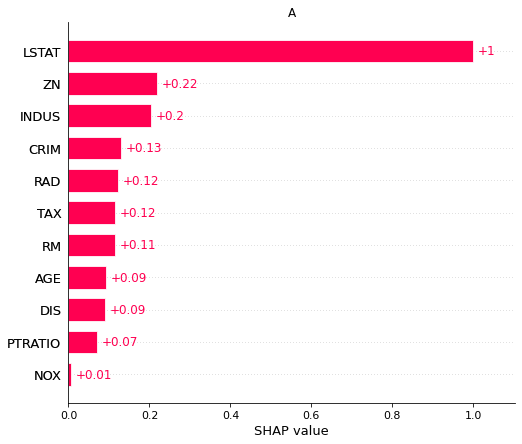

In [7]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['A.0', 'A.1', 'A.2']])
plot_feature_importance_bar(feature_importance, 'A', feature_order)

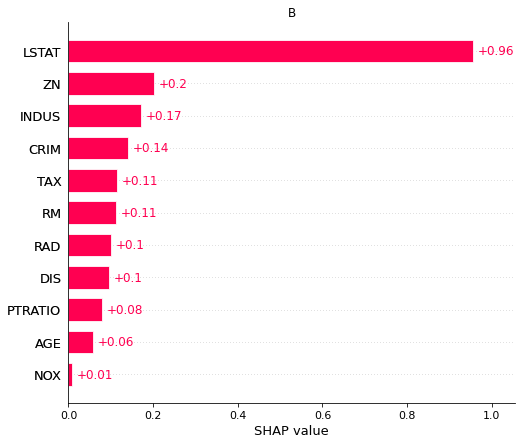

In [8]:
feature_order, feature_importance = calc_feature_order(indiv_shap_values[:, :, ['B.0', 'B.1', 'B.2']])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
feature_order, _ = calc_feature_order(indiv_shap_values)

In [11]:
feature_order = feature_order[:-1]

In [12]:
node = make_clustering(comparer, indiv_shap_values, categorical_features=categorical_features)

In [13]:
feature_it = iter(feature_order)

In [14]:
def plot_next_feature():
    feature = next(feature_it)
    for classes in zip(['A.0', 'A.1', 'A.2'], ['B.0', 'B.1', 'B.2']):
        node.plot_feature_dependence(feature, classes=list(classes), alpha=0.5)

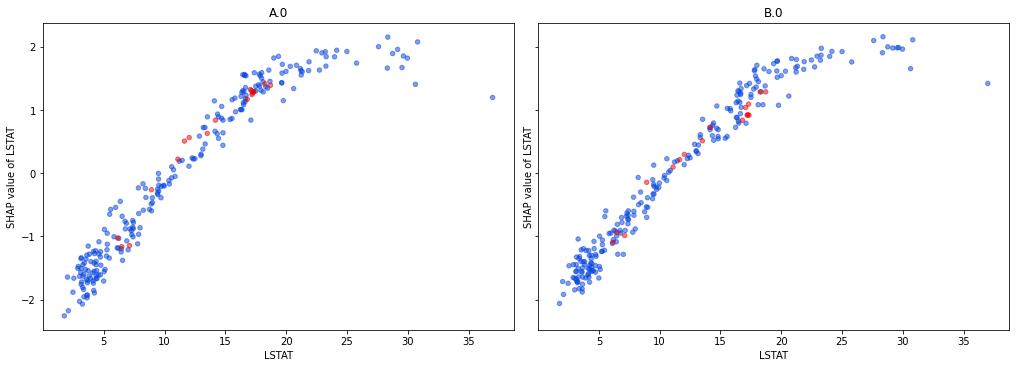

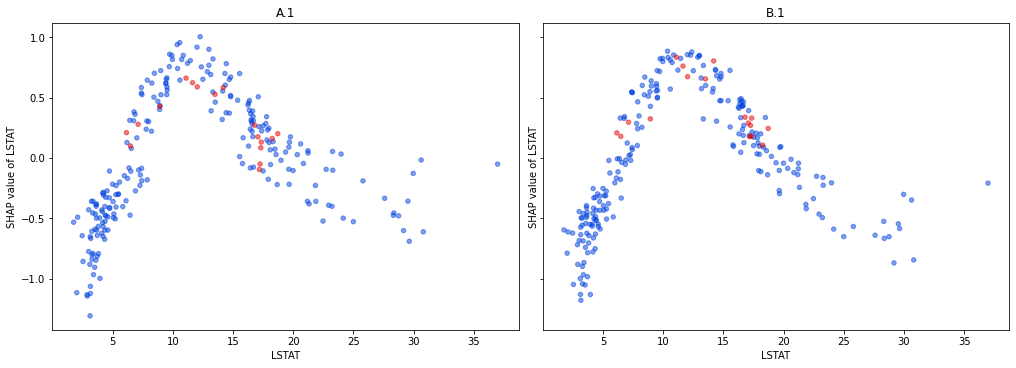

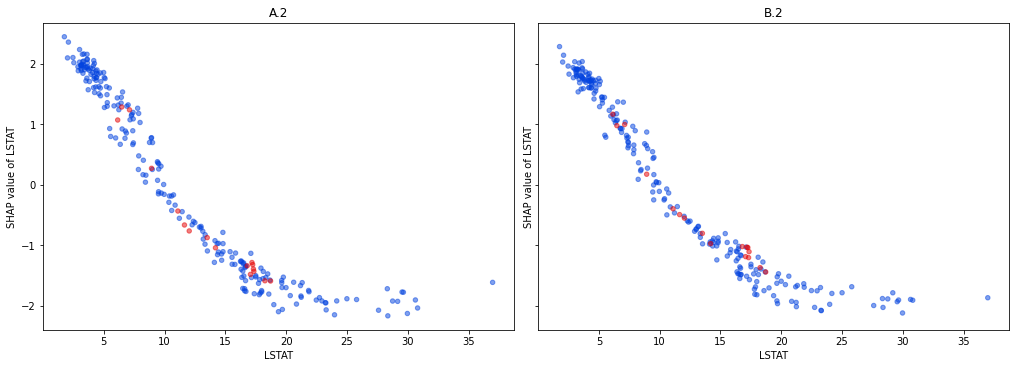

In [15]:
plot_next_feature()

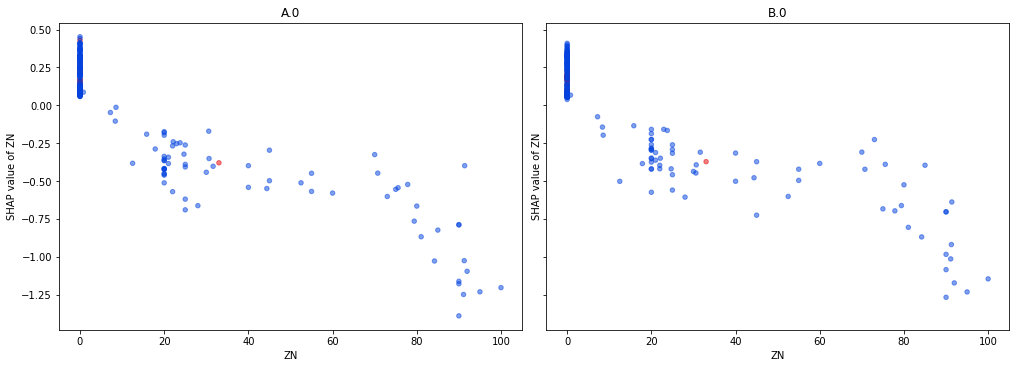

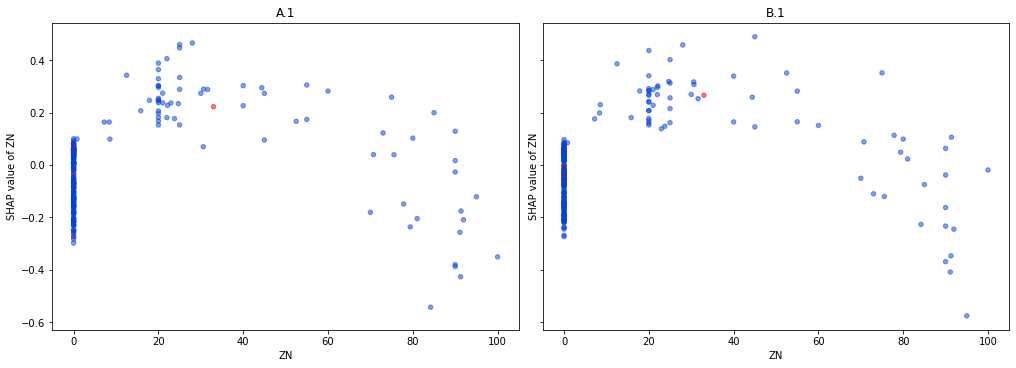

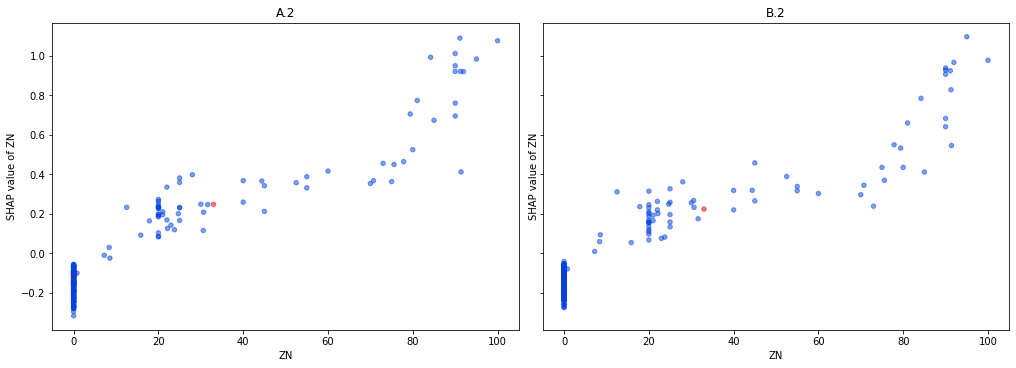

In [10]:
plot_next_feature()

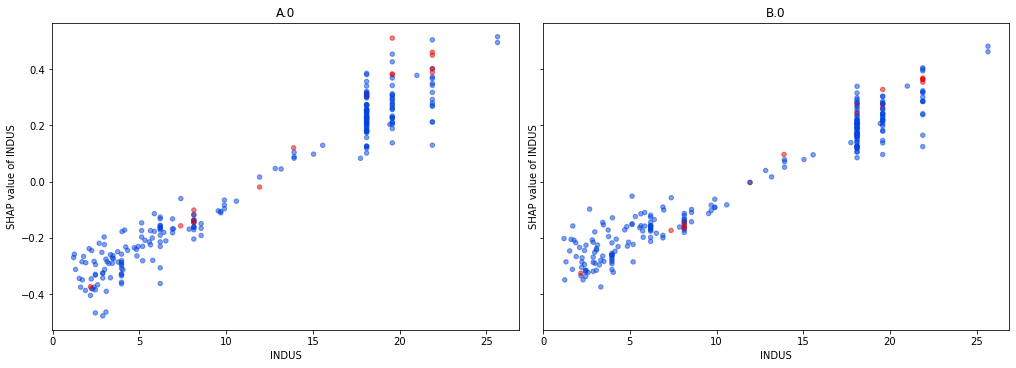

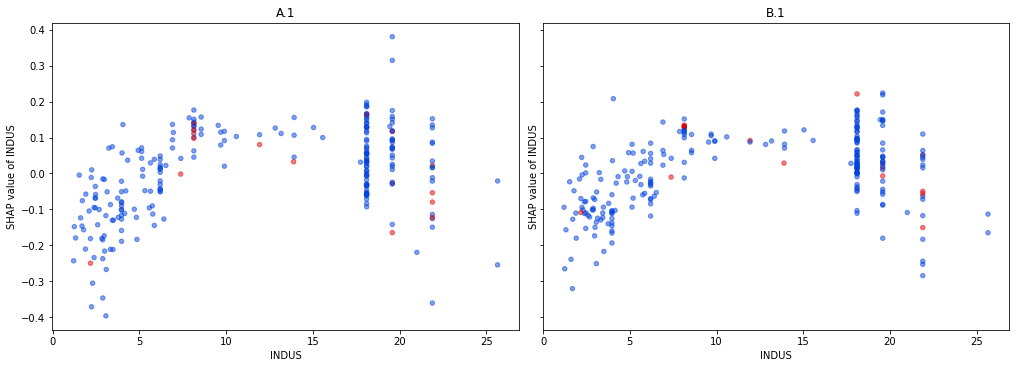

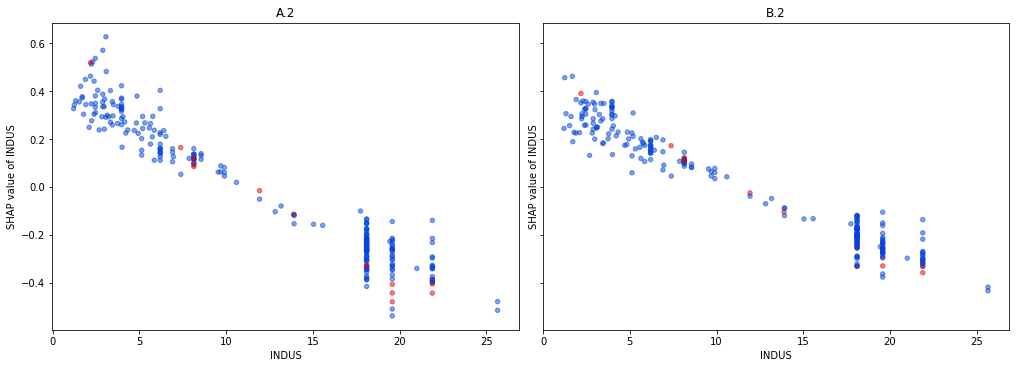

In [11]:
plot_next_feature()

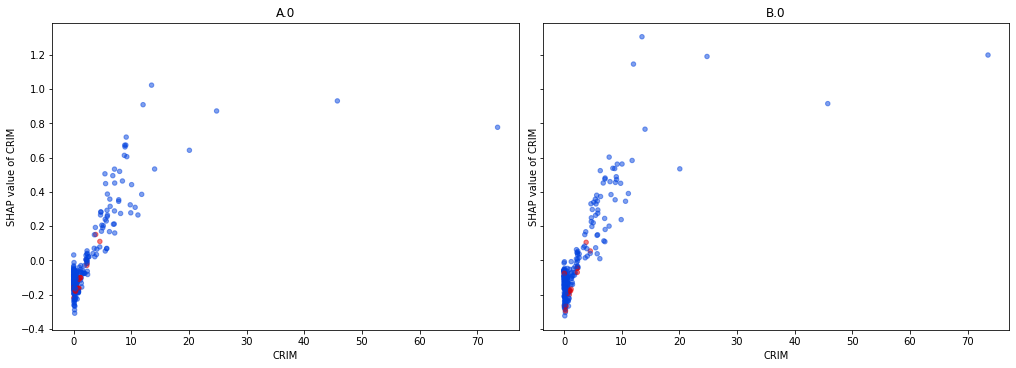

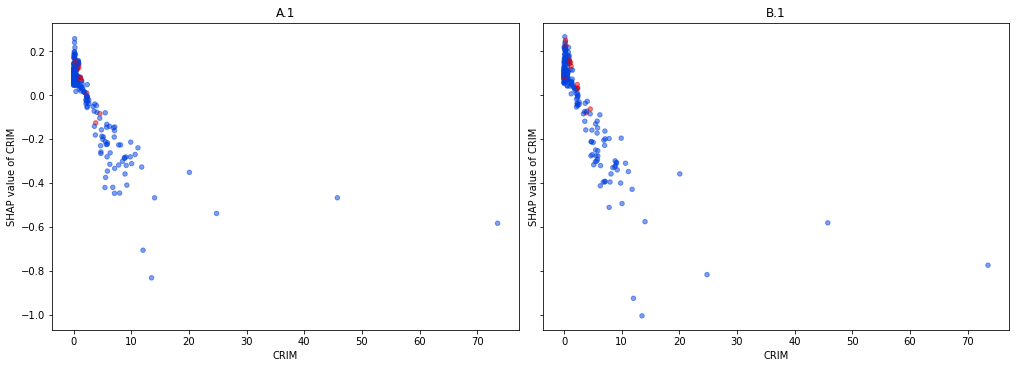

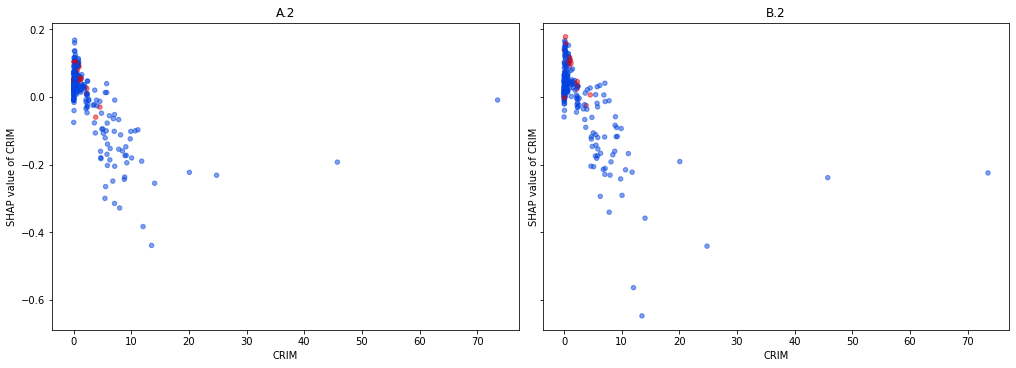

In [12]:
plot_next_feature()

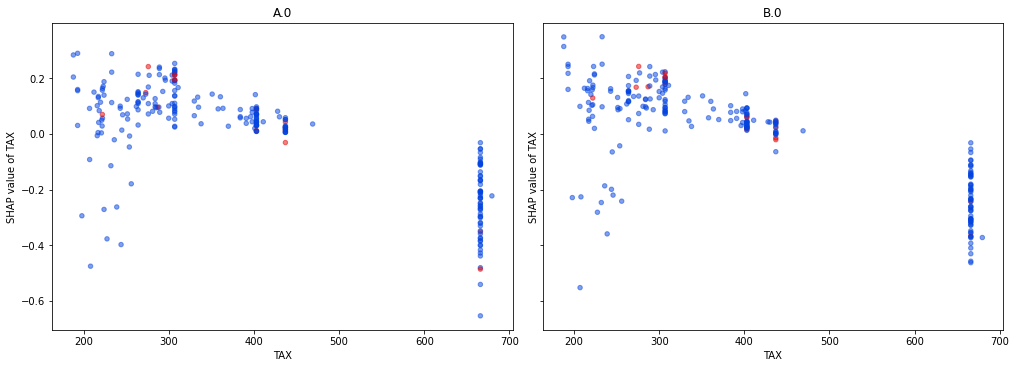

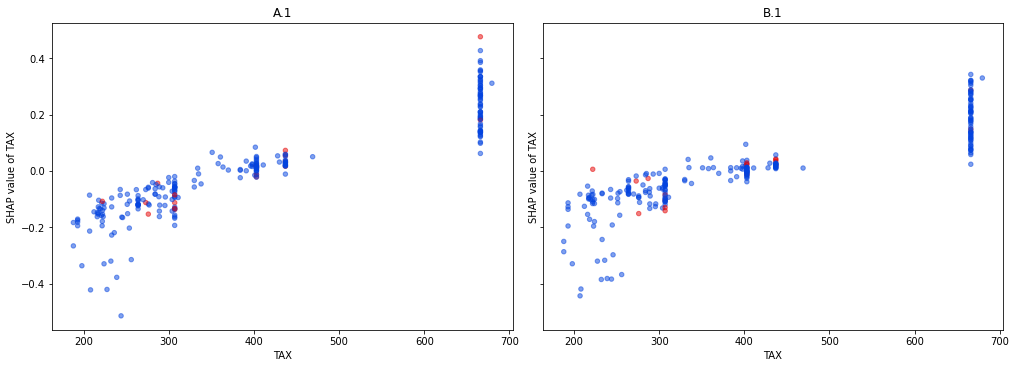

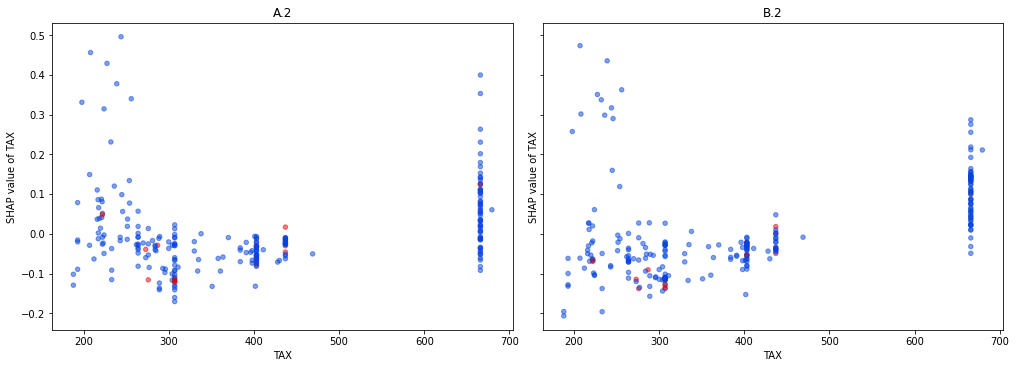

In [13]:
plot_next_feature()

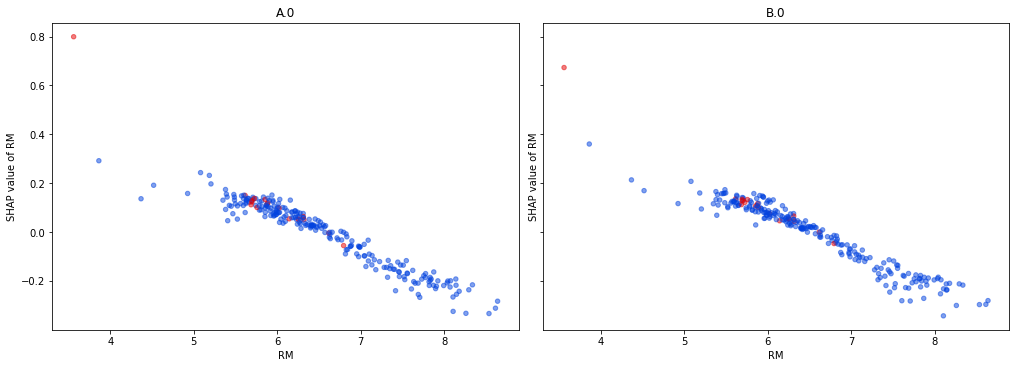

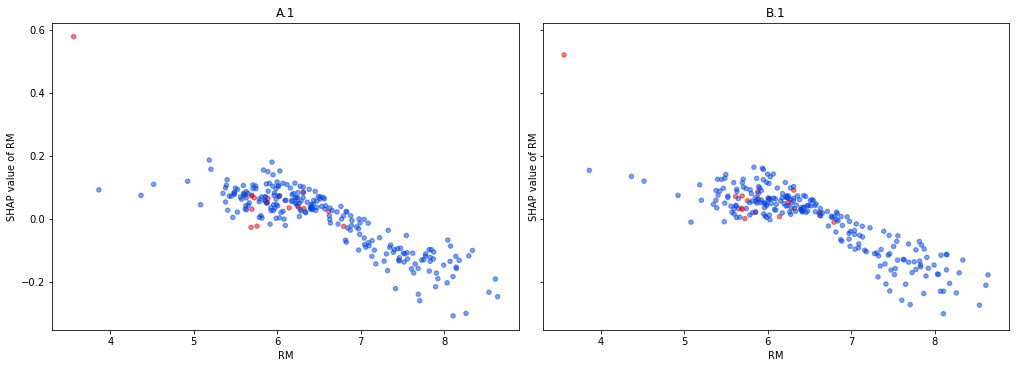

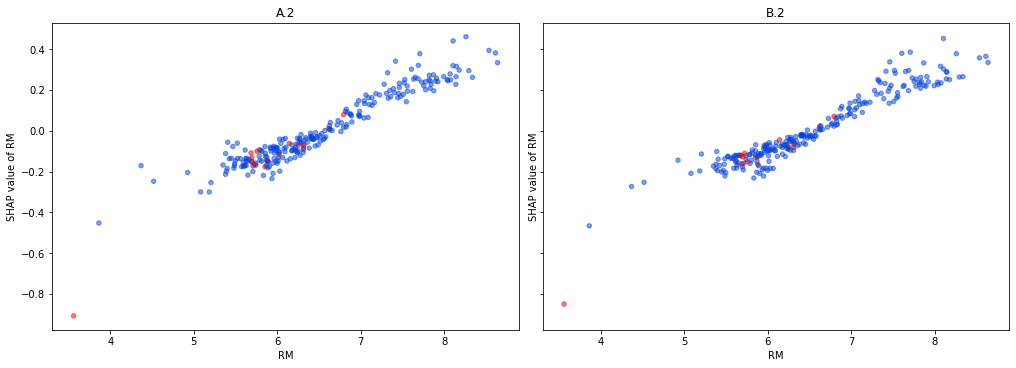

In [14]:
plot_next_feature()

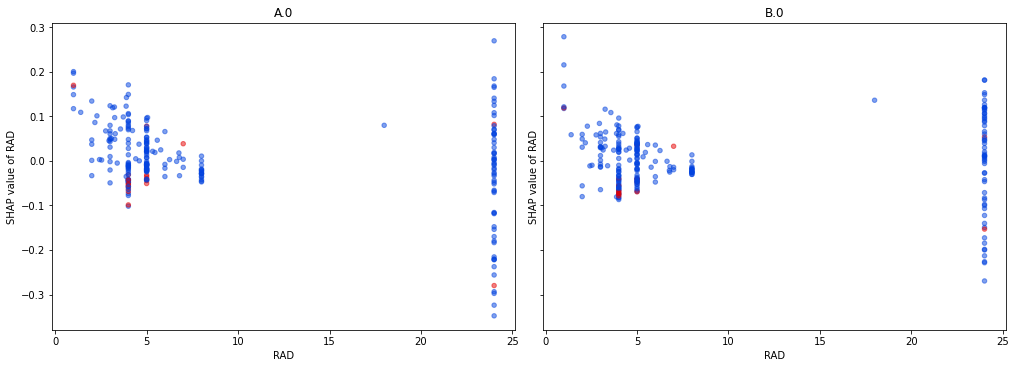

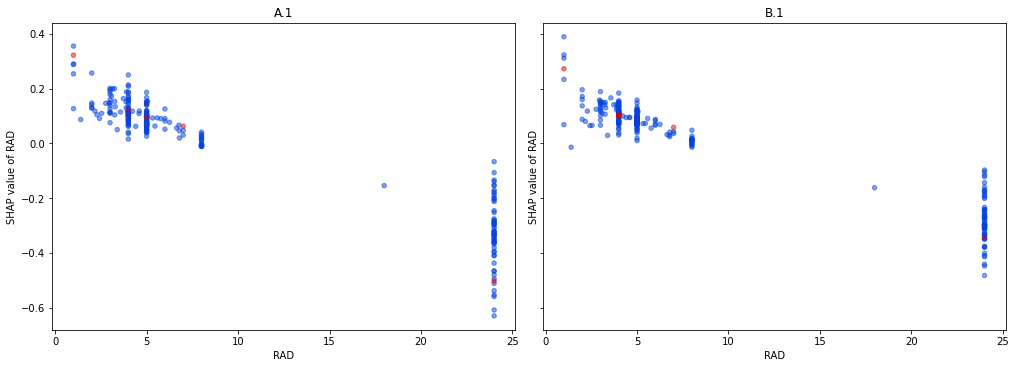

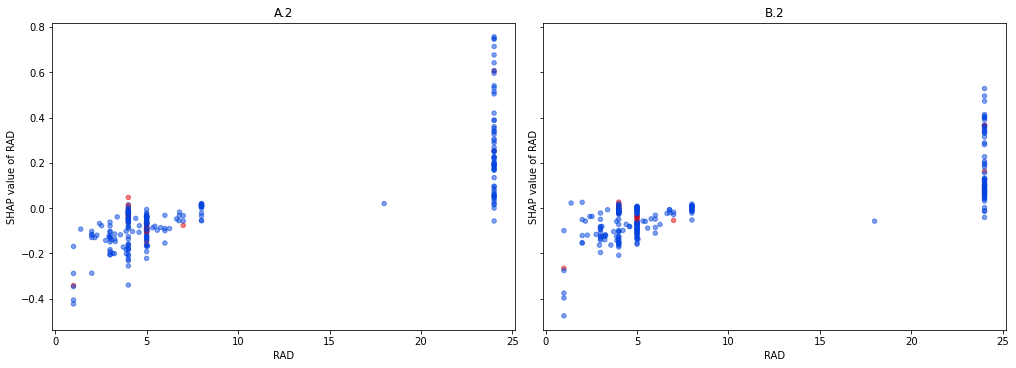

In [15]:
plot_next_feature()

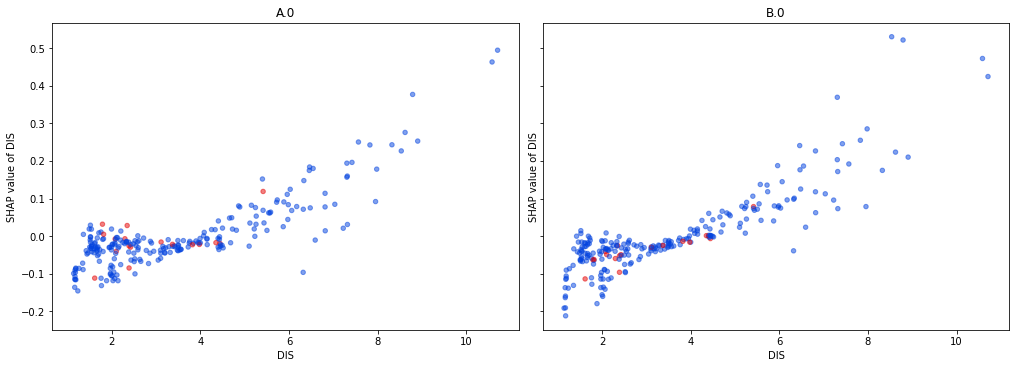

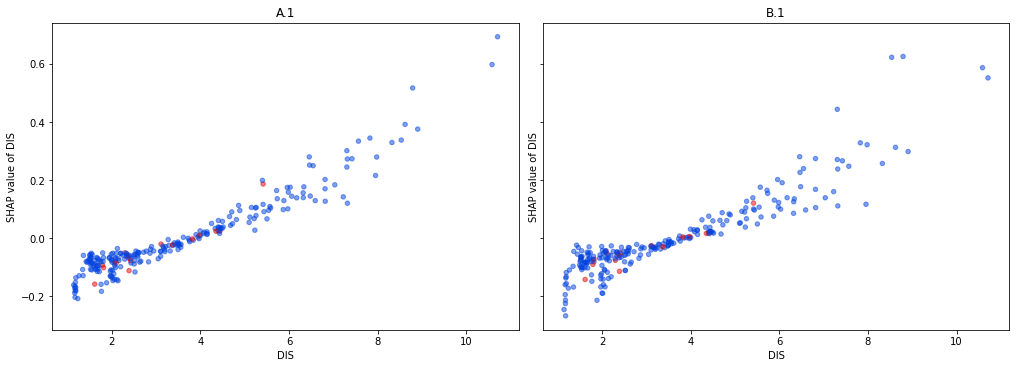

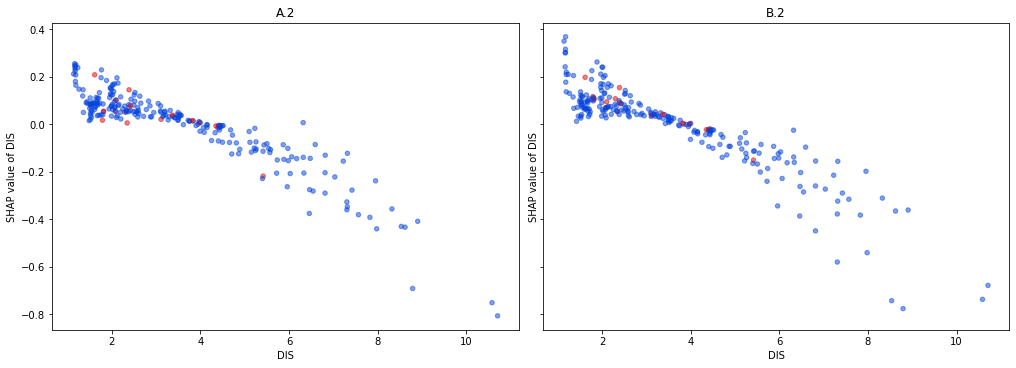

In [16]:
plot_next_feature()

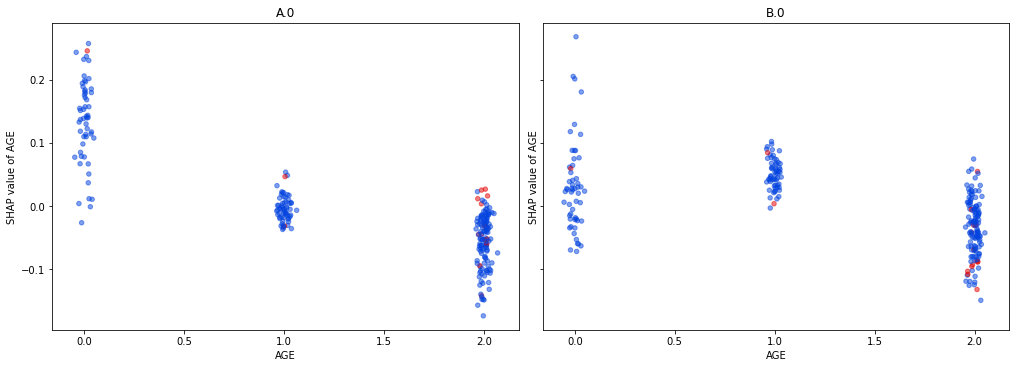

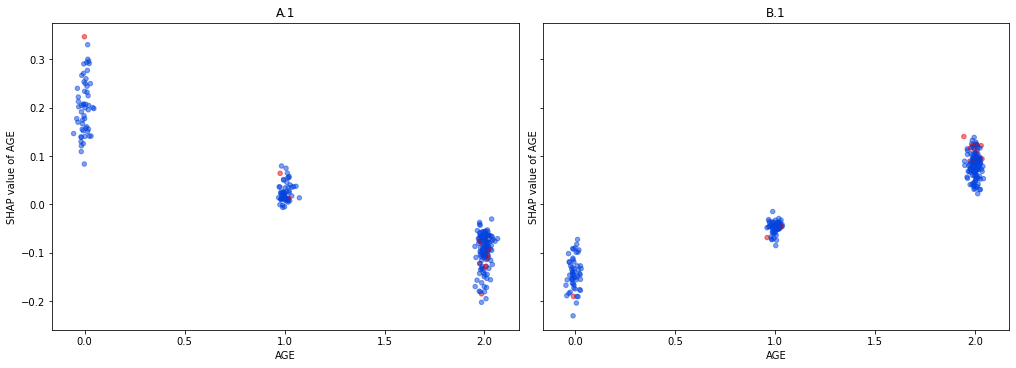

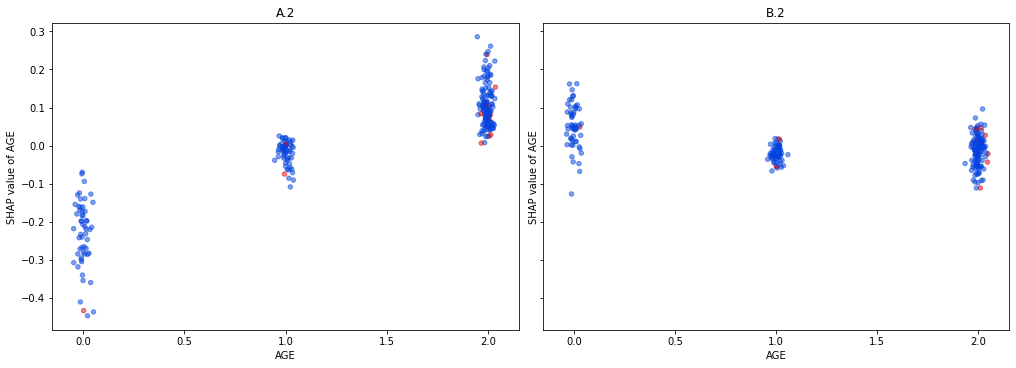

In [17]:
plot_next_feature()

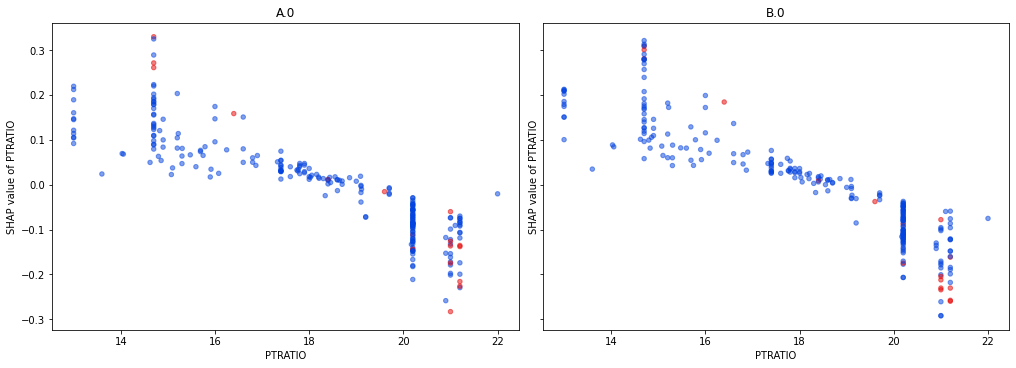

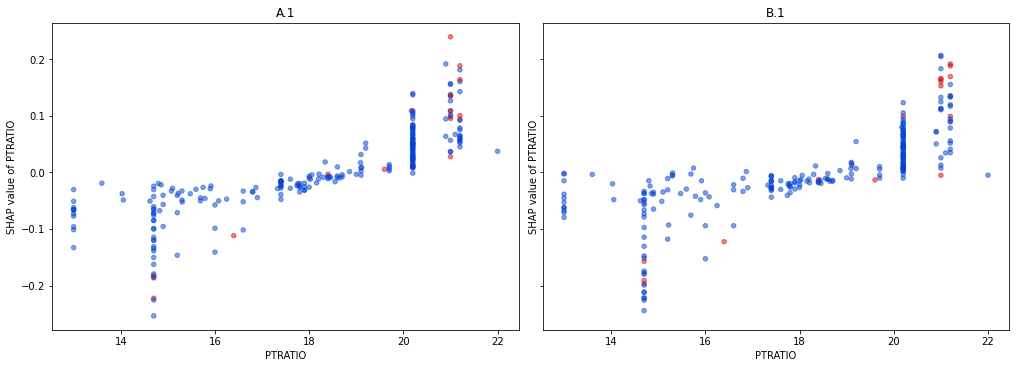

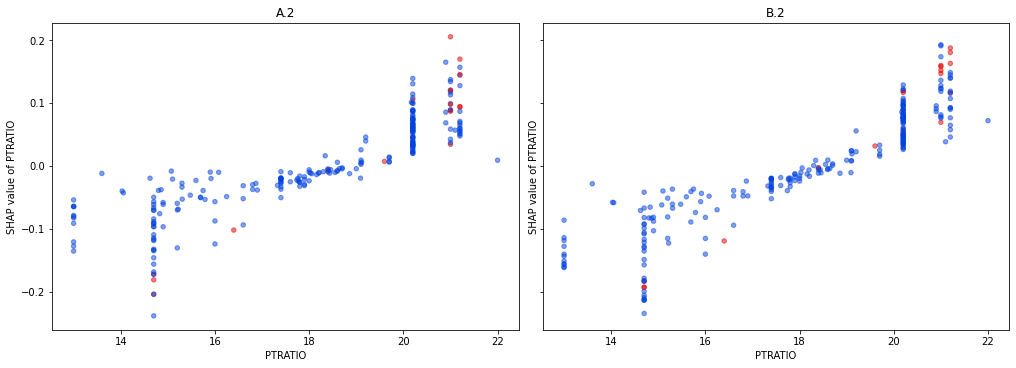

In [18]:
plot_next_feature()

# Difference Classifier SHAP Explanations

In [16]:
with open('diffclf.permutation.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

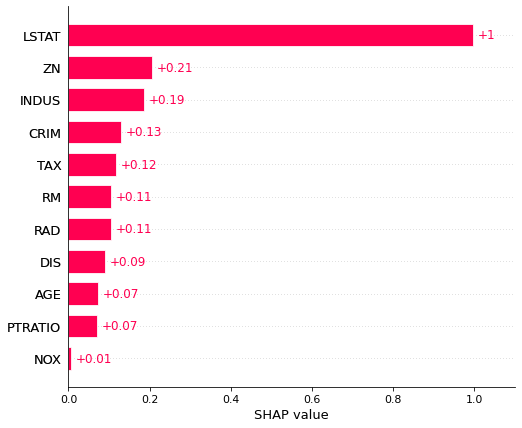

In [17]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

In [18]:
feature_order = feature_order[:-1]

The equality classes (0,0) and (2,2) have the highest mean absolute SHAP value, which means that the influences to and from these classes are highest. 

(0,2) and (2,0) have the least importances.

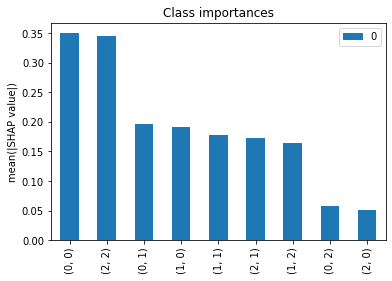

In [19]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

In [20]:
class_order = np.sort(class_order[:-2])

## Clustering of Class $(0,1)$ SHAP Values

In [21]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 5.8 s, sys: 28.2 ms, total: 5.83 s
Wall time: 5.9 s


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.97803187230072)

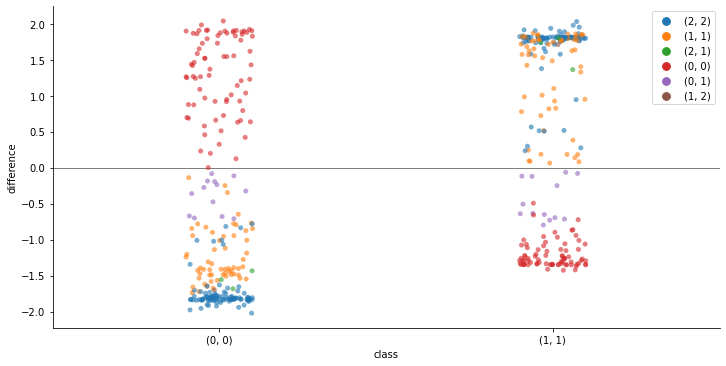

{'(0, 0)': '-0.71 to -0.08', '(1, 1)': '-0.8 to -0.06'}


In [12]:
node.plot_outcome_differences()

### Node RLR

In [13]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLR,
 (0, 0)    76
 (1, 1)    15
 (0, 1)    13
 dtype: int64,
 12.019438010465088)

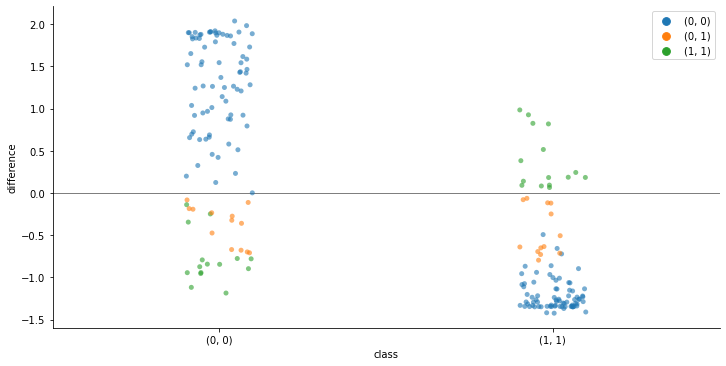

{'(0, 0)': '-0.71 to -0.08', '(1, 1)': '-0.8 to -0.06'}


In [14]:
node.plot_outcome_differences()

11.1 <= LSTAT <= 18.72
LSTAT <= 10.24 --> {'(1, 1)': 13}
LSTAT >= 19.17 --> {'(0, 0)': 13}


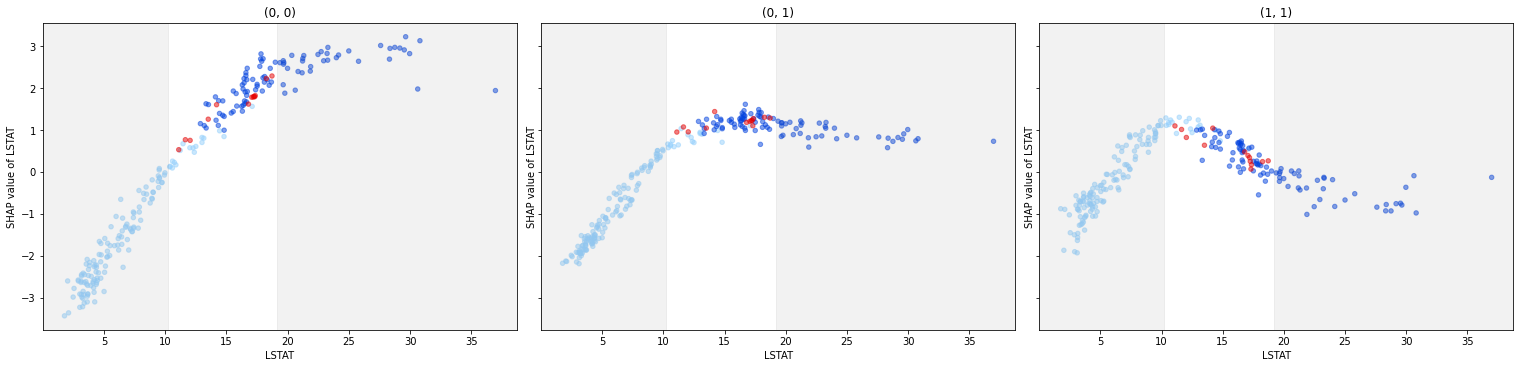

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 13}


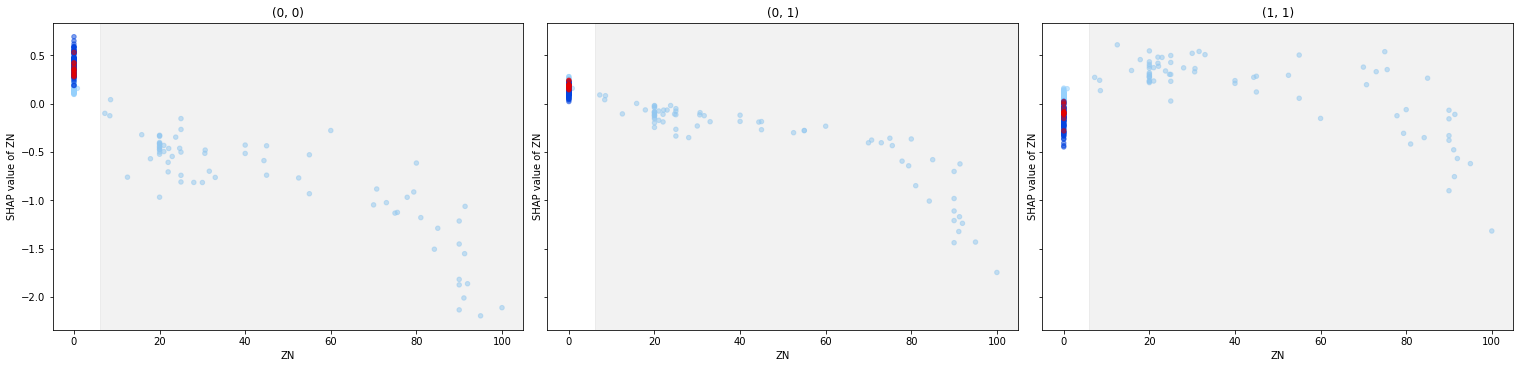

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 13}


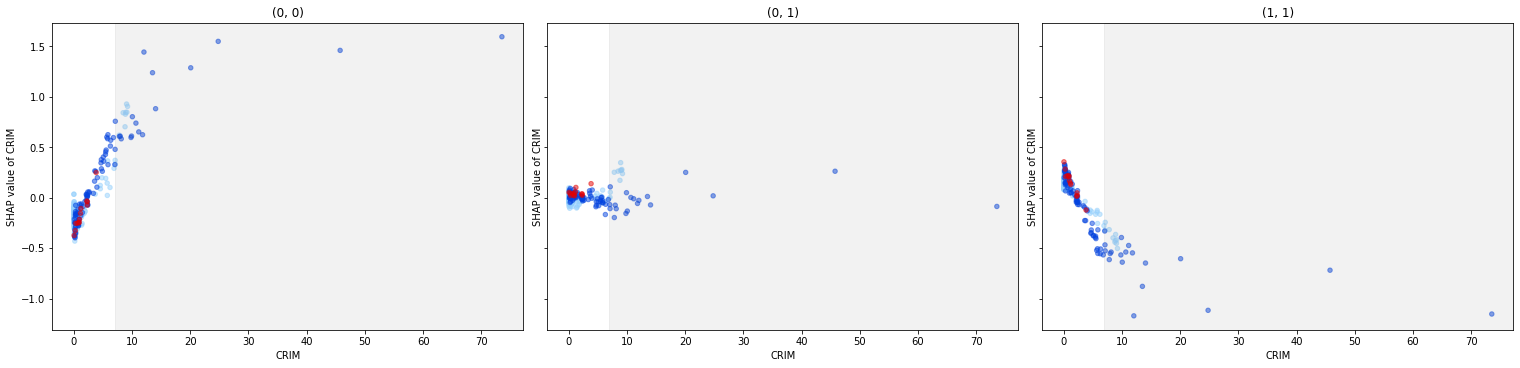

1.0 <= AGE
AGE <= 0.0 --> {'(0, 0)': 8, '(1, 0)': 5}


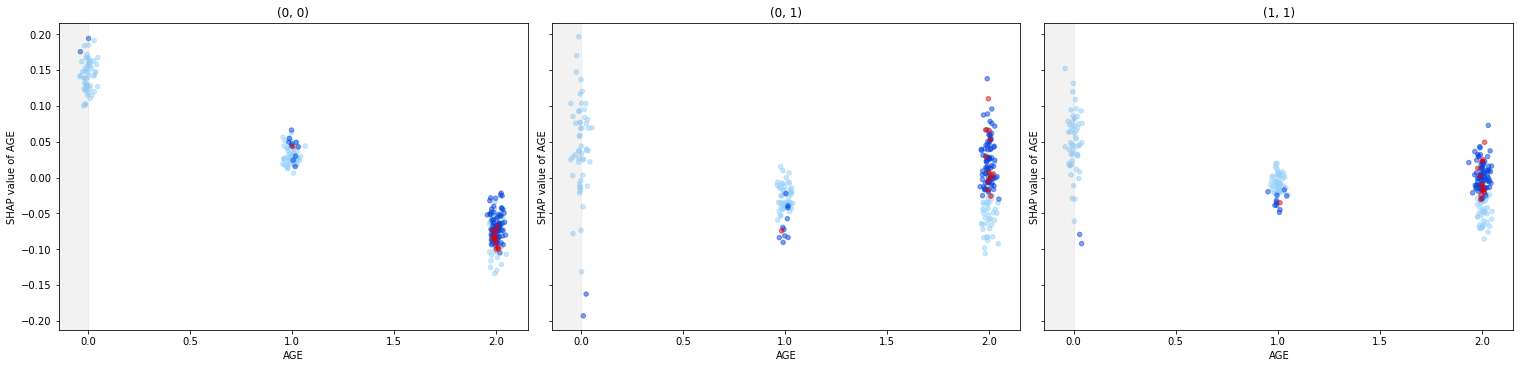

In [11]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

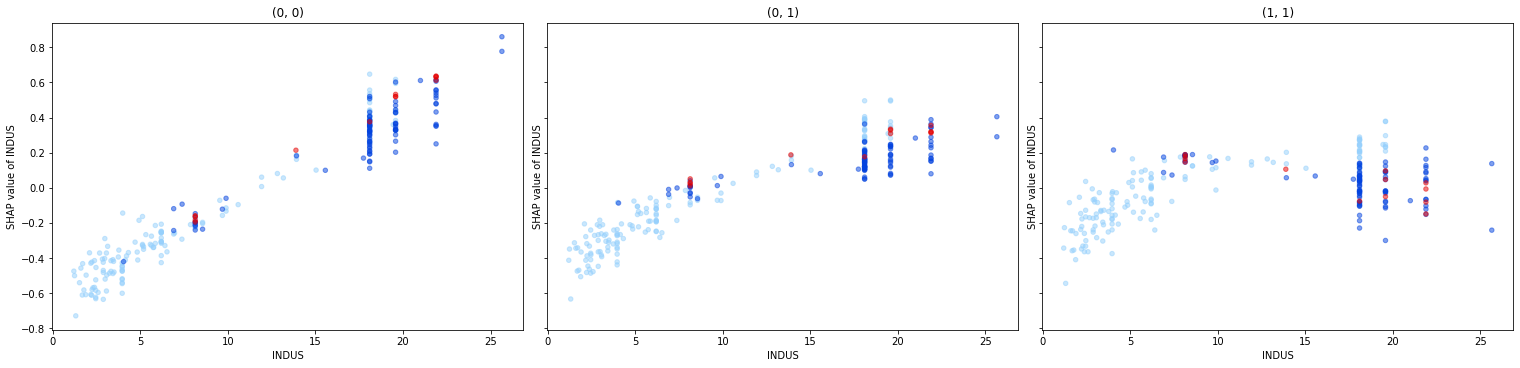

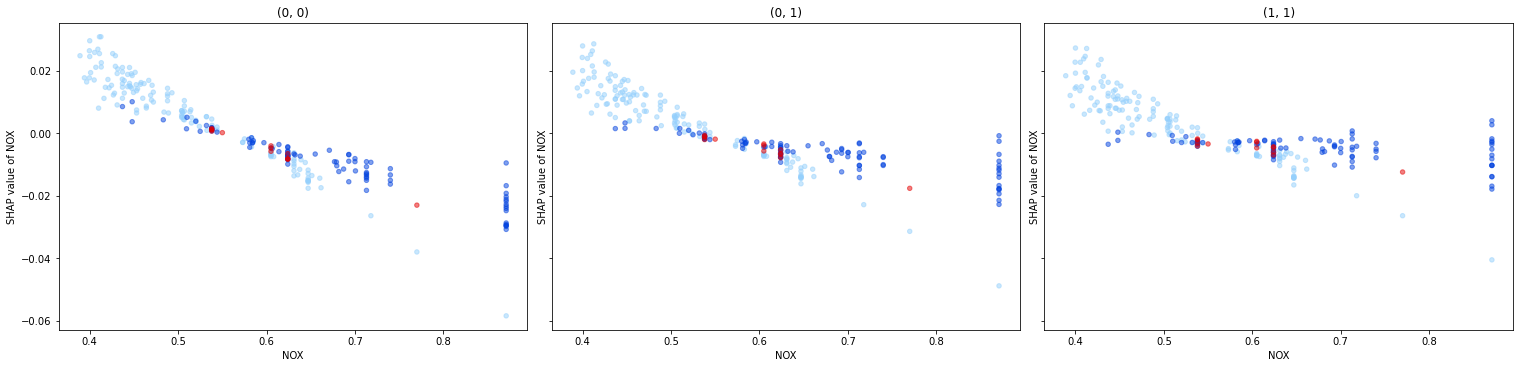

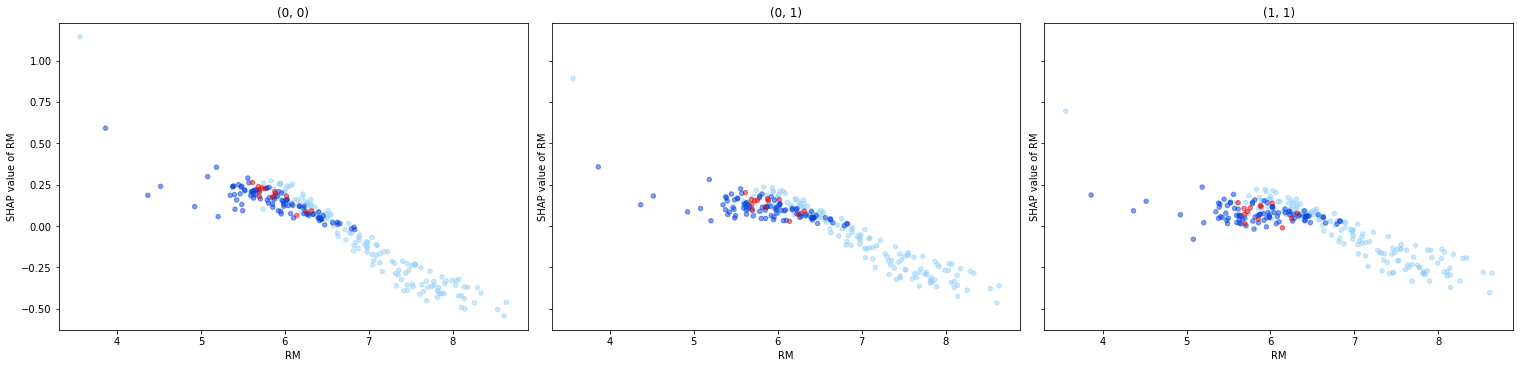

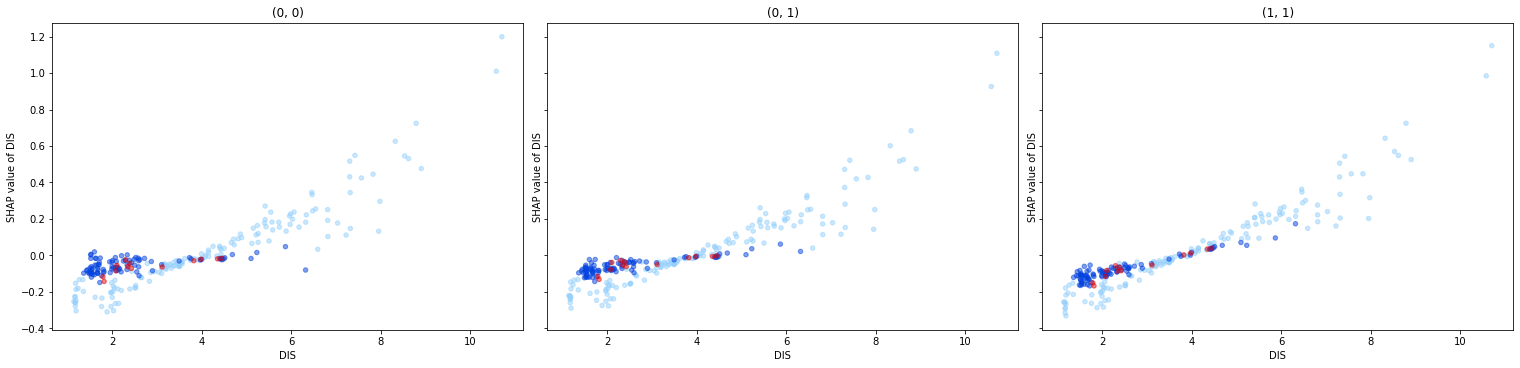

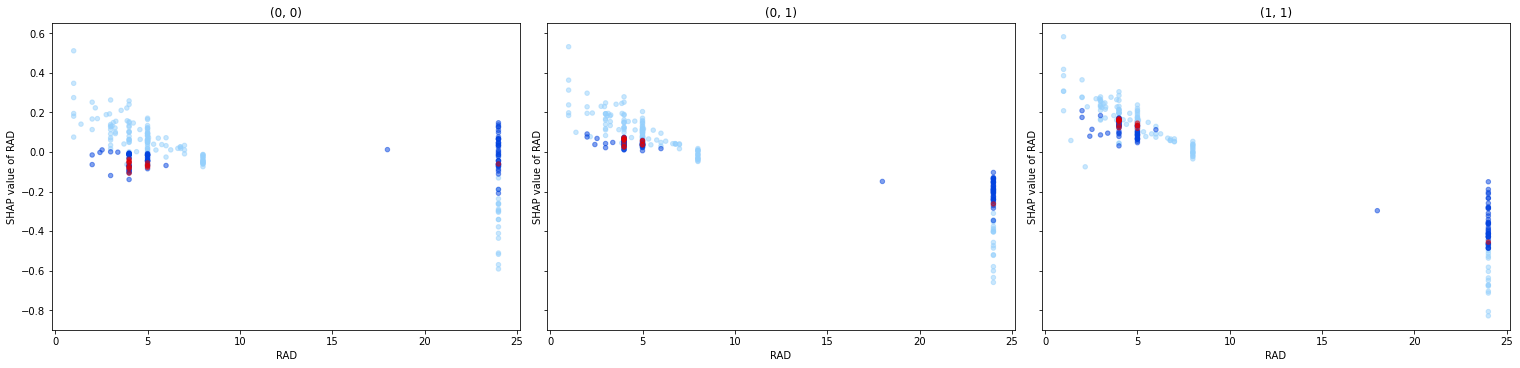

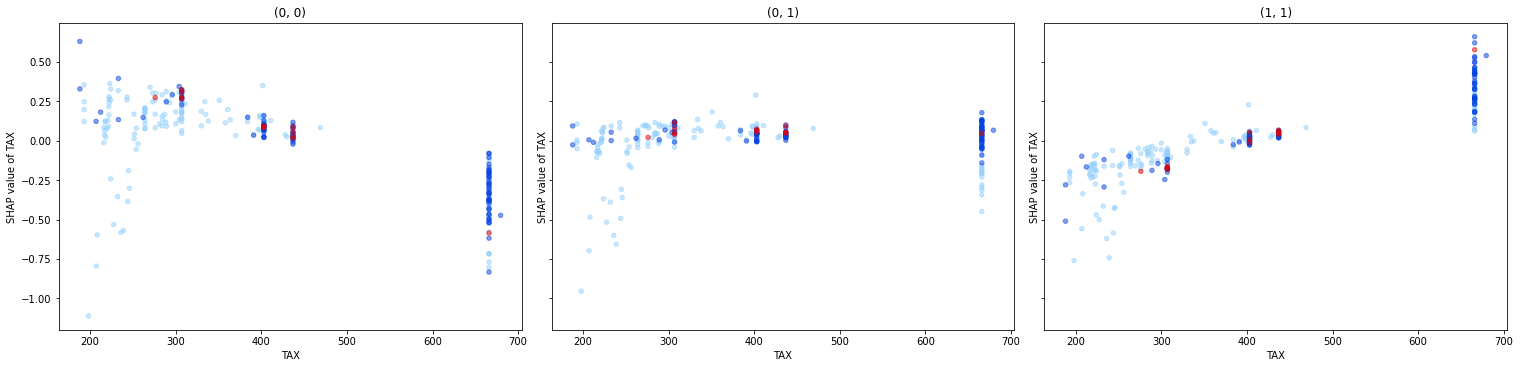

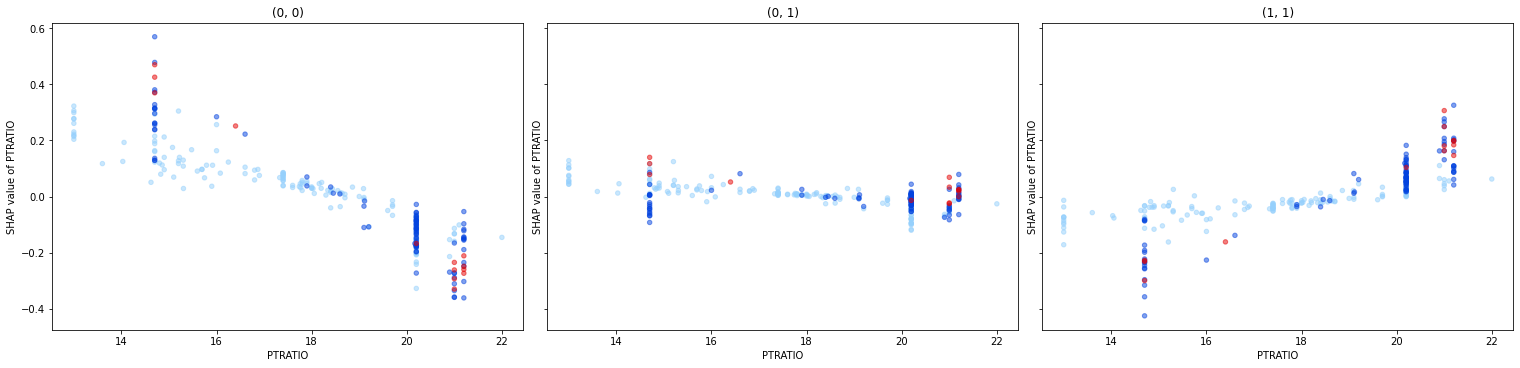

In [12]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

11.1 <= LSTAT <= 18.72
LSTAT <= 10.24 --> {'(1, 1)': 13}
LSTAT >= 19.17 --> {'(0, 0)': 13}


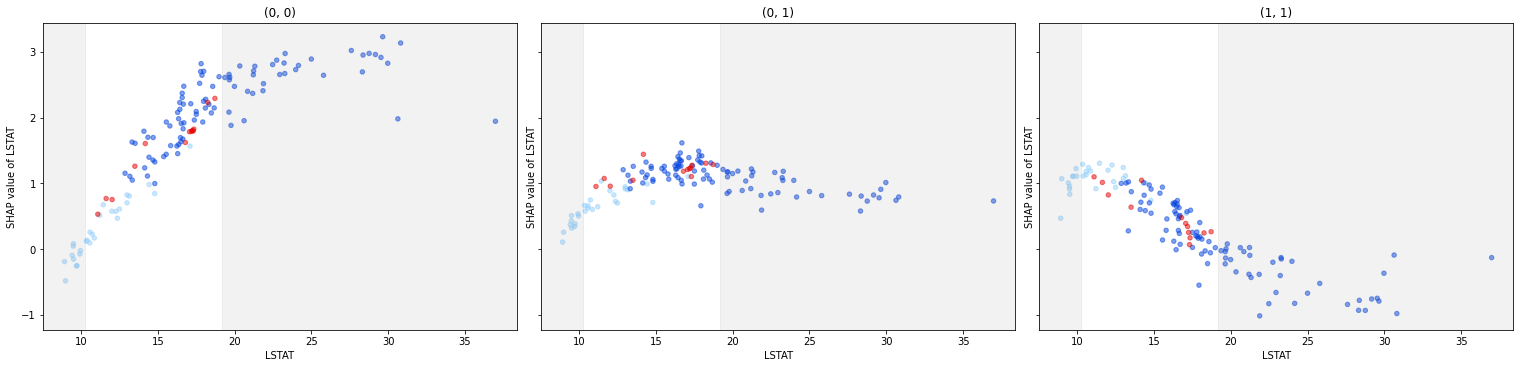

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 13}


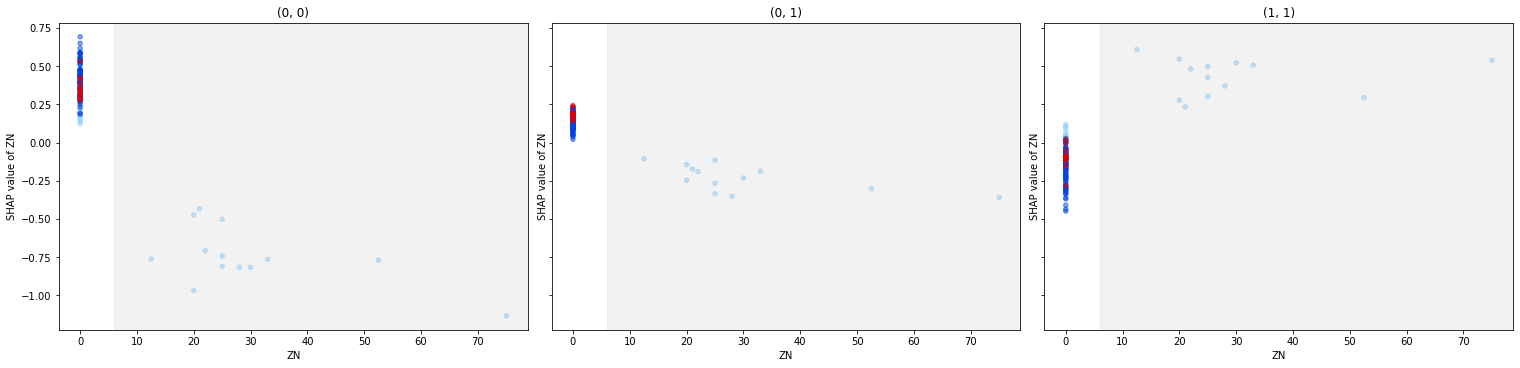

0.0456 <= CRIM <= 3.83684
CRIM >= 7.0 --> {'(0, 0)': 13}


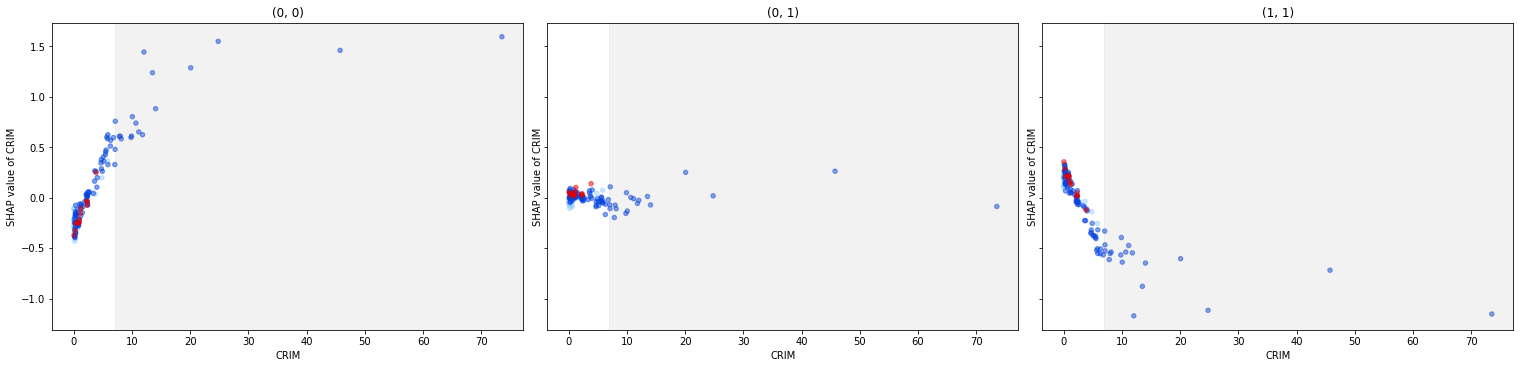

In [28]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

I doubt that the second global explanation is a good one, because most instances have ZN=0. Checking these instances, we can see that there are many with ZN=0 which are in the LSTAT range of differences:

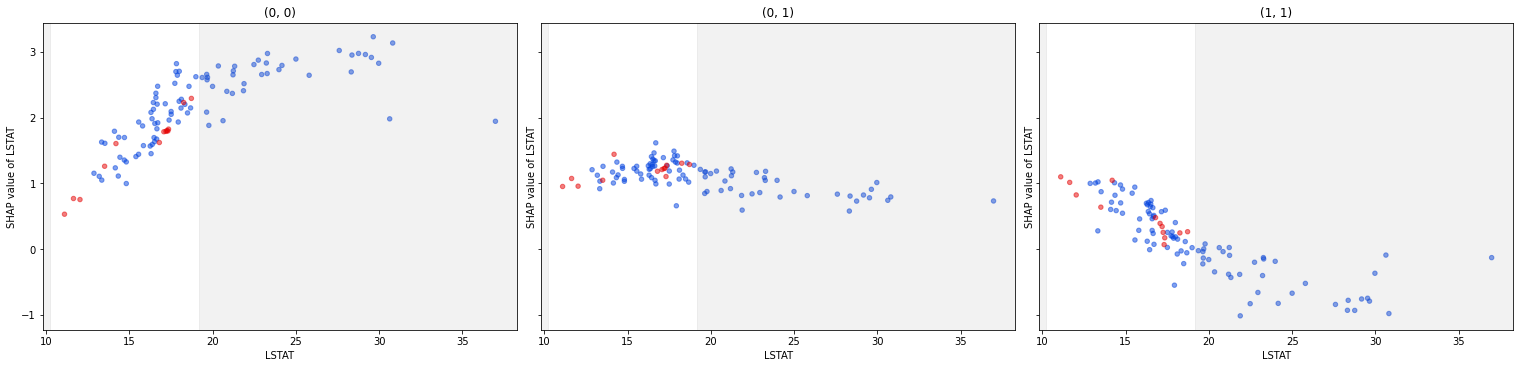

In [15]:
part = node.filter(node.shap_values[:, 'ZN'].data < 1)
part.plot_feature_dependence('LSTAT', alpha=0.5)

CRIM is also not a good explanation, because most instances are below the upper counterfactual.

### Node RLRLRLR

In [15]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRLR,
 (0, 1)    2
 dtype: int64,
 0.06588988962112206)

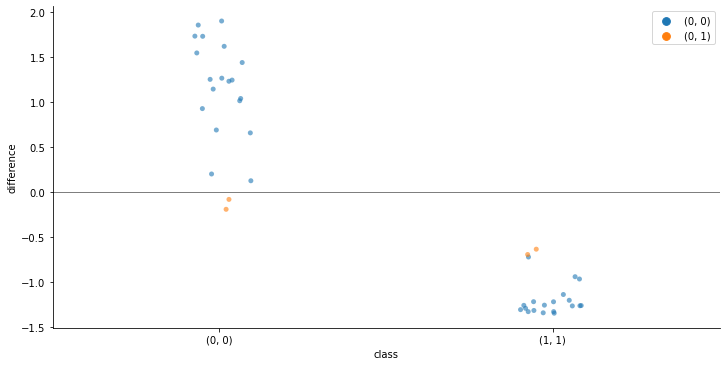

{'(0, 0)': '-0.19 to -0.08', '(1, 1)': '-0.69 to -0.64'}


In [19]:
node.get_parent(2).plot_outcome_differences()

18.25726553185902 <= LSTAT <= 18.72
LSTAT <= 16.39 --> {'(1, 1)': 2}
LSTAT >= 18.95 --> {'(0, 0)': 2}


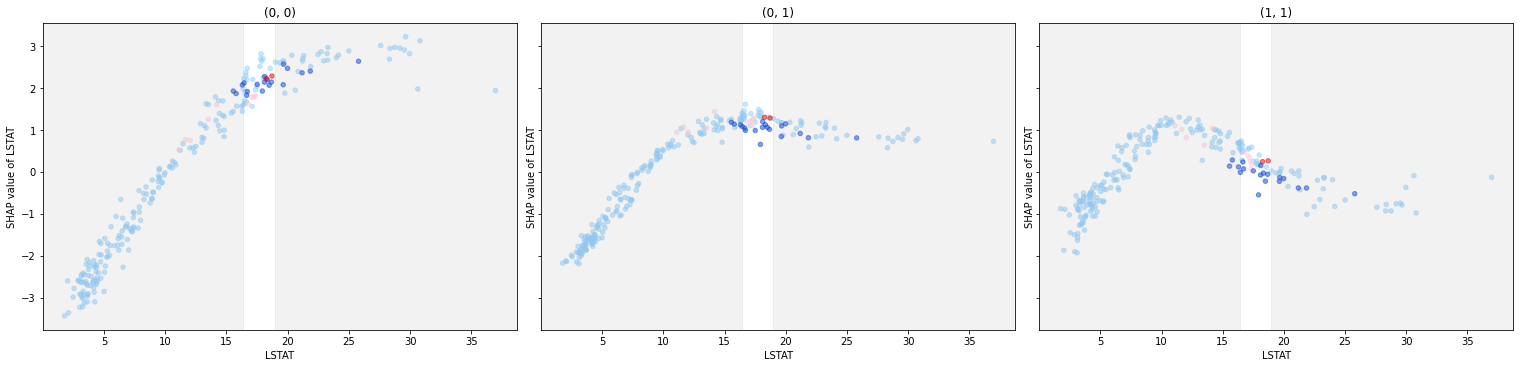

ZN == 0.0
ZN >= 6.0 --> {'(1, 1)': 2}


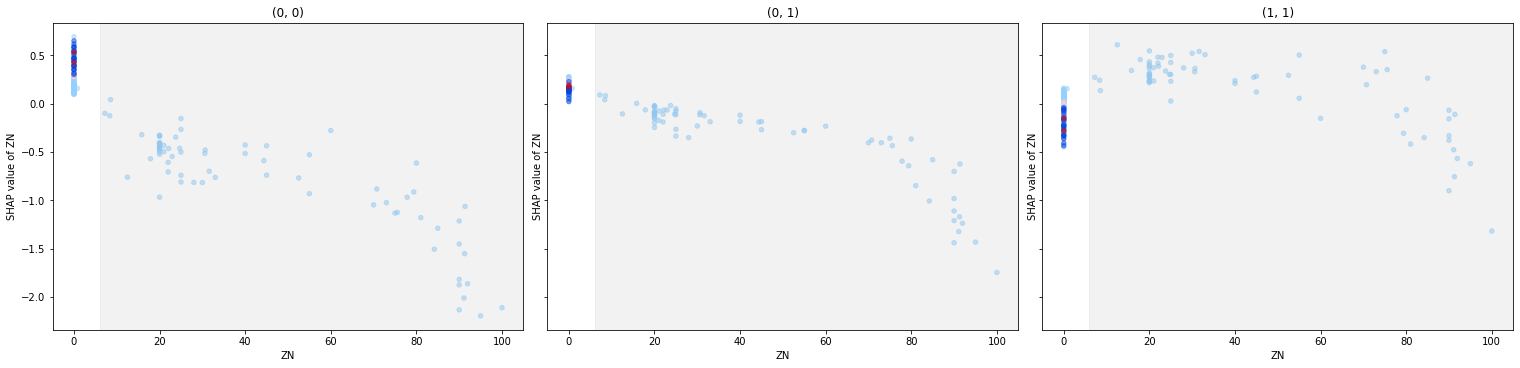

PTRATIO == 21.0
PTRATIO <= 20.07 --> {'(0, 0)': 2}


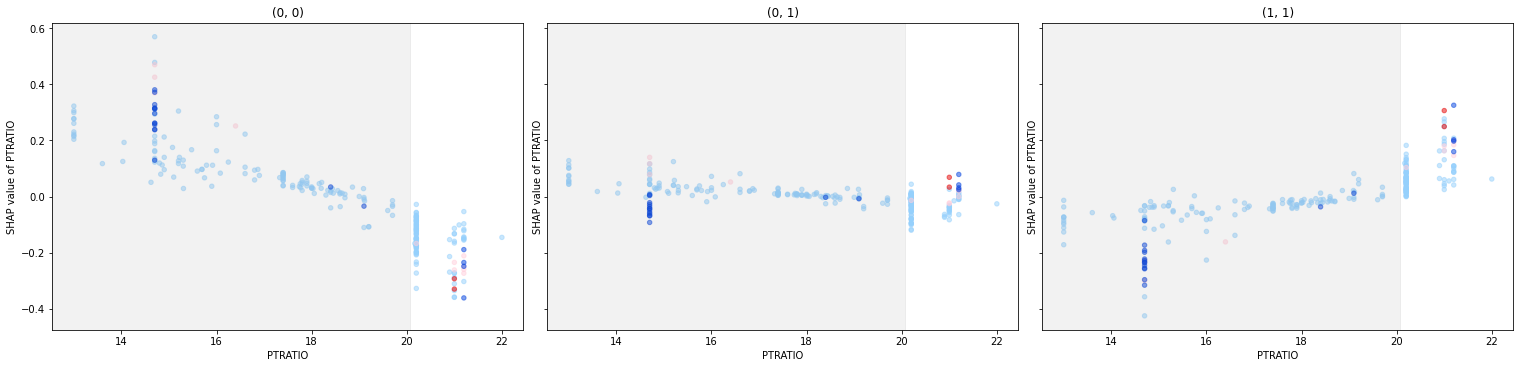

In [20]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(2), alpha=0.5)

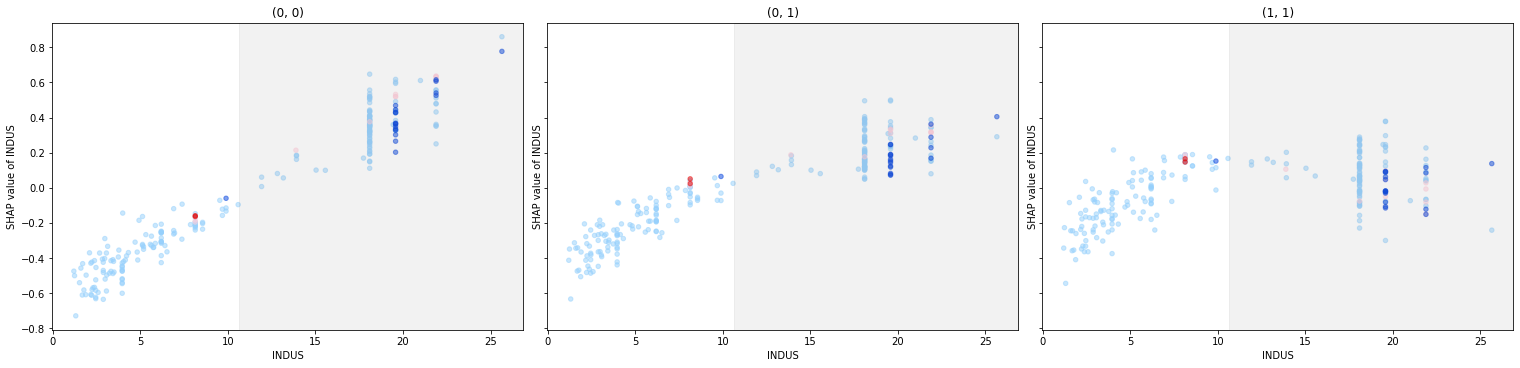

In [21]:
node.root.plot_feature_dependence('INDUS', focus=node.get_parent(2), alpha=0.5)

I already argued, that ZN alone is not a sufficient explanation. But the third most important feature INDUS and its low upper counterfactual provides a good explanation for these two instances.

### Node RLRRR

In [22]:
node = node.root.get('RLRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRR,
 (1, 1)    15
 (0, 0)    11
 (0, 1)    11
 dtype: int64,
 5.1794988864017935)

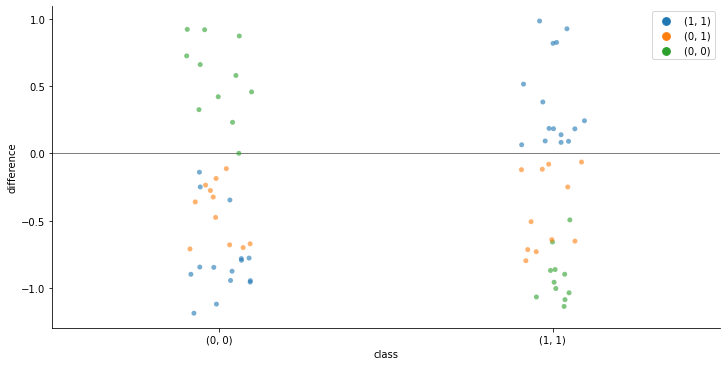

{'(0, 0)': '-0.71 to -0.11', '(1, 1)': '-0.8 to -0.06'}


In [23]:
node.plot_outcome_differences()

11.1 <= LSTAT <= 17.348228318163887
LSTAT <= 10.24 --> {'(1, 1)': 11}
LSTAT >= 19.17 --> {'(0, 0)': 11}


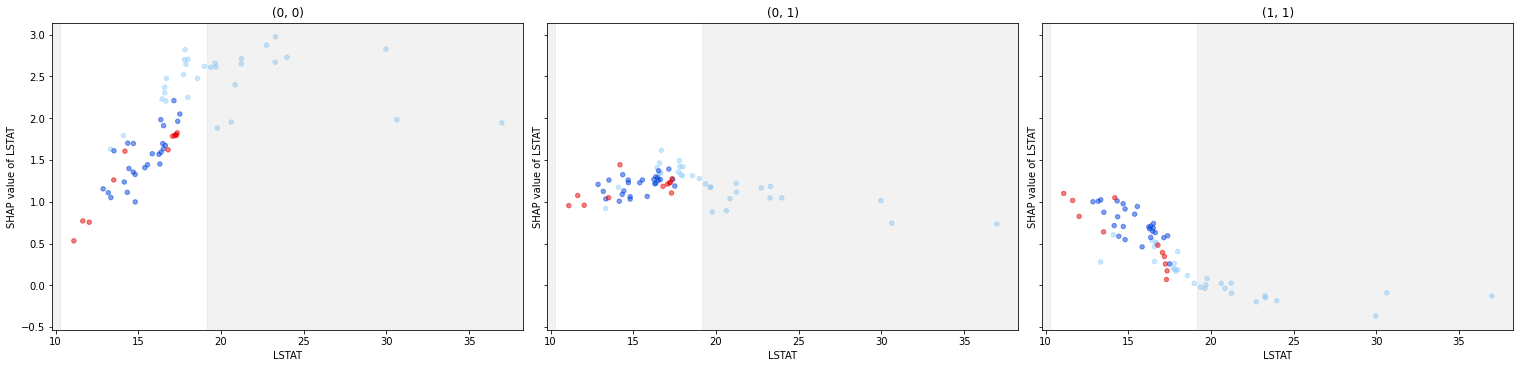

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 11}


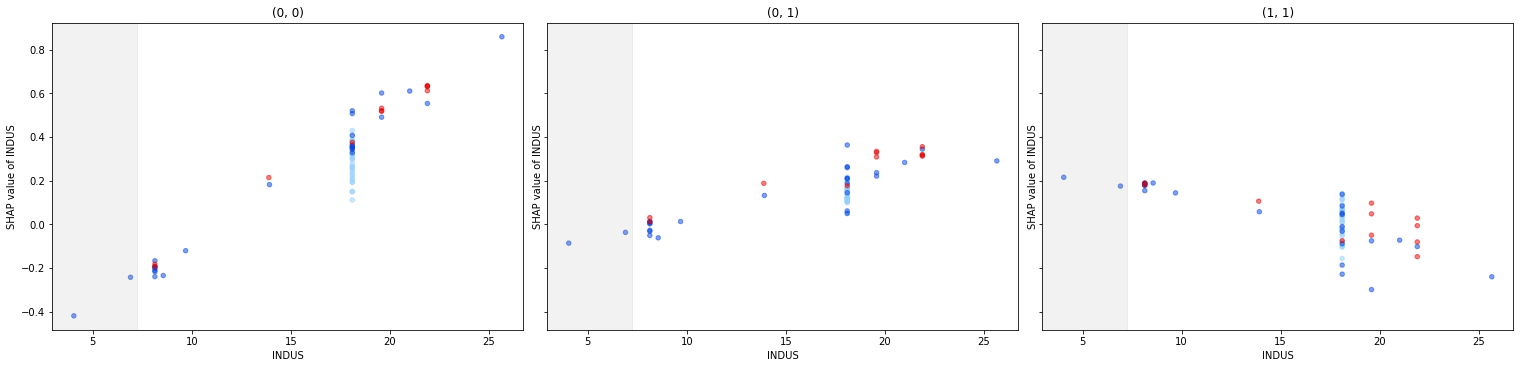

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 11}


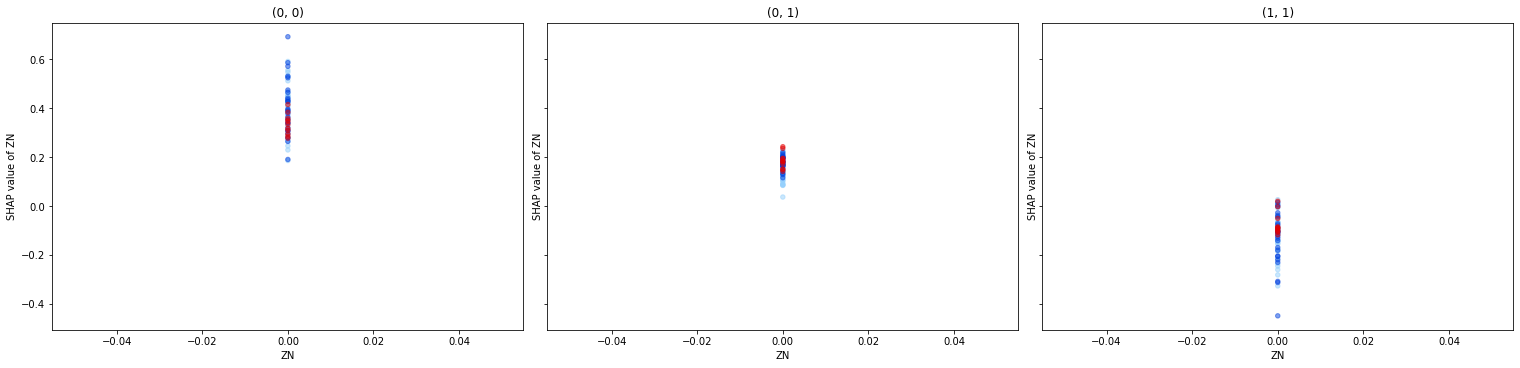

In [35]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

The explanations are not much different from the global explanations and the cluster difference is still quite high compared to the last cluster's explanation. I will try with more precise explanations.

### Node RLRRRLLRRL

In [24]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRLLRRL,
 (0, 1)    1
 dtype: int64,
 0)

Just a single instance left to explain

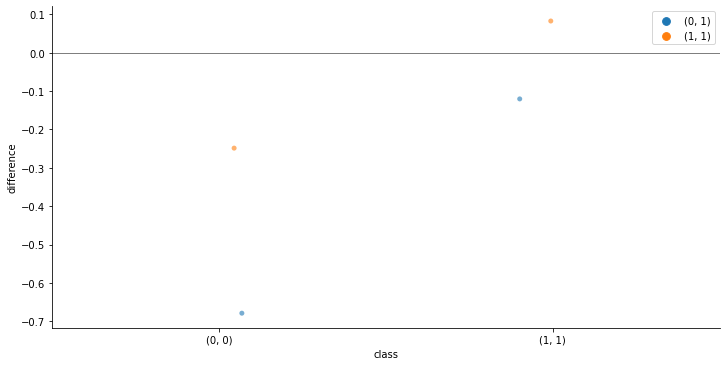

{'(0, 0)': '-0.68 to -0.68', '(1, 1)': '-0.12 to -0.12'}


In [35]:
node.get_parent().plot_outcome_differences()

LSTAT == 14.19
LSTAT <= 13.9 --> {'(1, 1)': 1}
LSTAT >= 16.13 --> {'(0, 0)': 1}


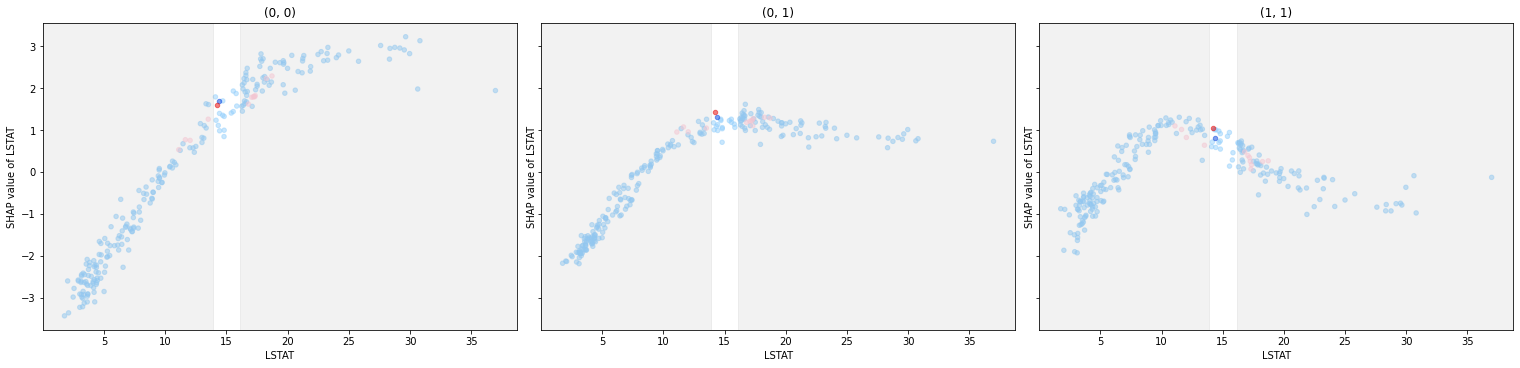

TAX == 666.0
TAX <= 499.0 --> {'(0, 0)': 1}


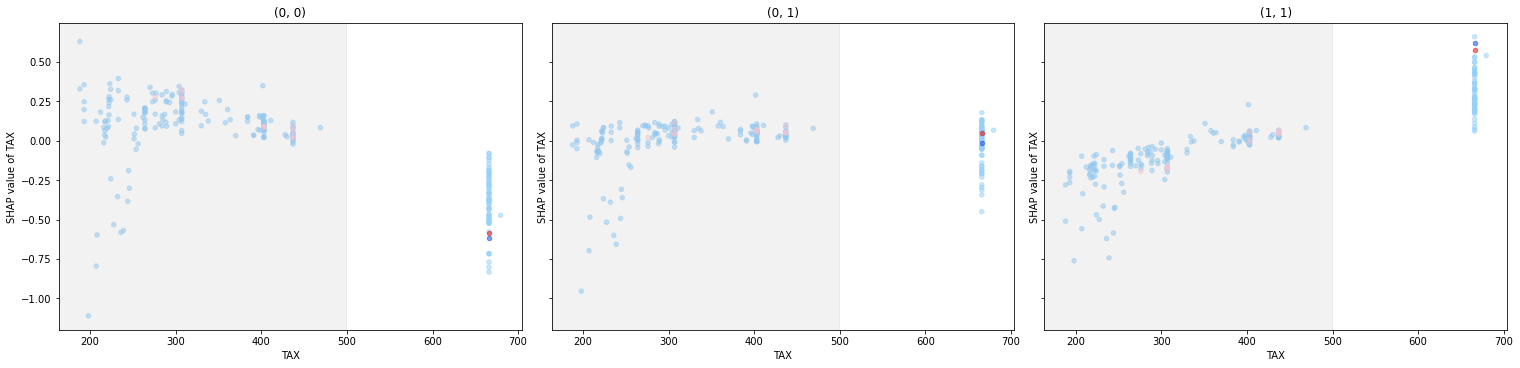

INDUS == 18.1
INDUS <= 16.87 --> {'(1, 1)': 1}


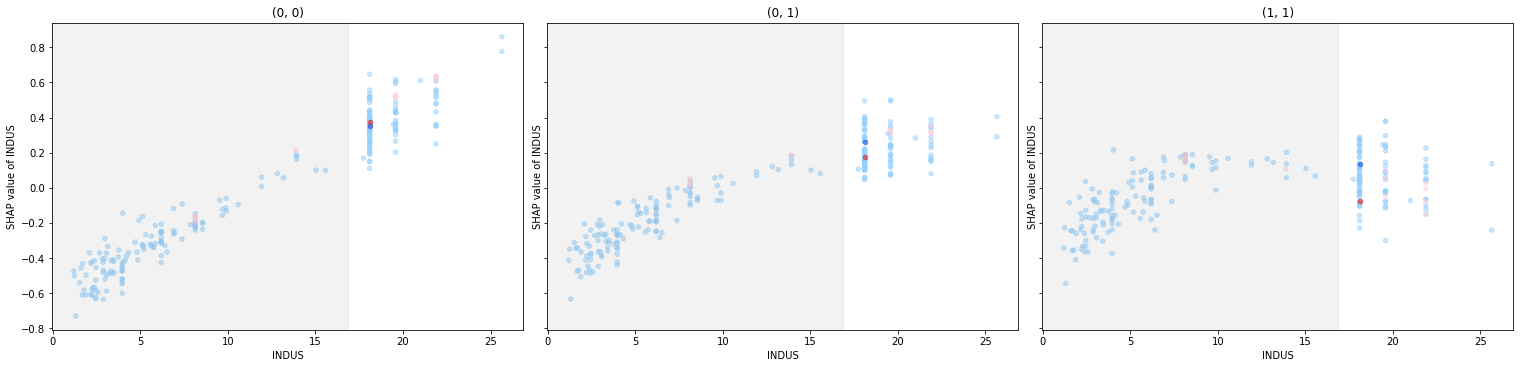

RAD == 24.0
RAD <= 21.4 --> {'(1, 1)': 1}


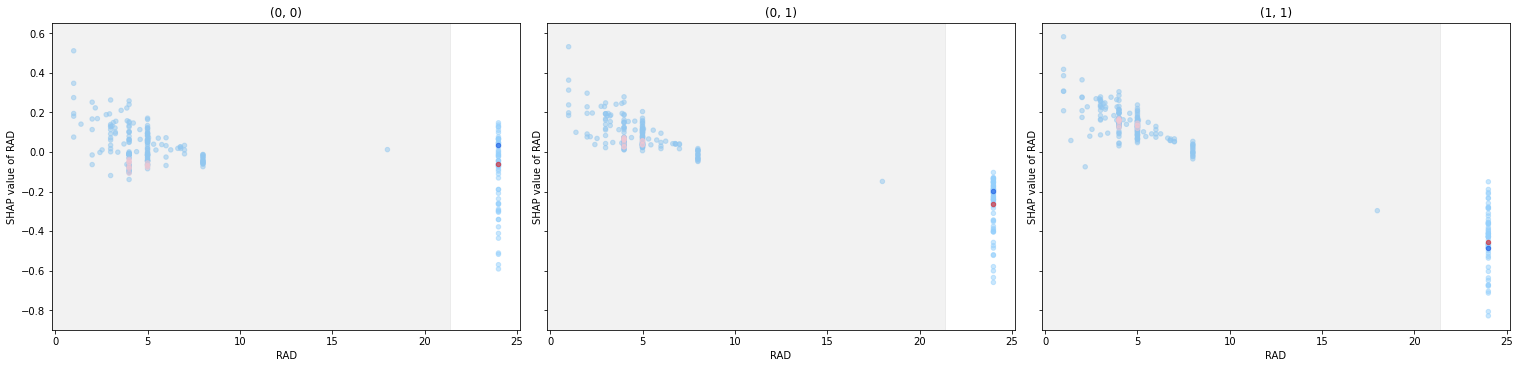

ZN == 0.0
ZN >= 1.0 --> {'(1, 1)': 1}


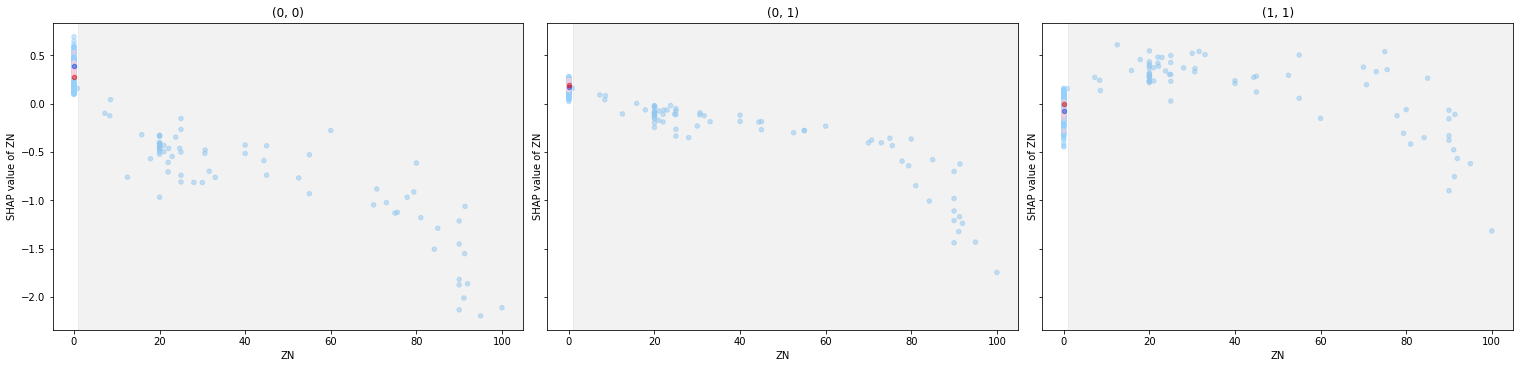

CRIM == 3.83684
CRIM <= 3.0 --> {'(1, 1)': 1}
CRIM >= 7.0 --> {'(0, 0)': 1}


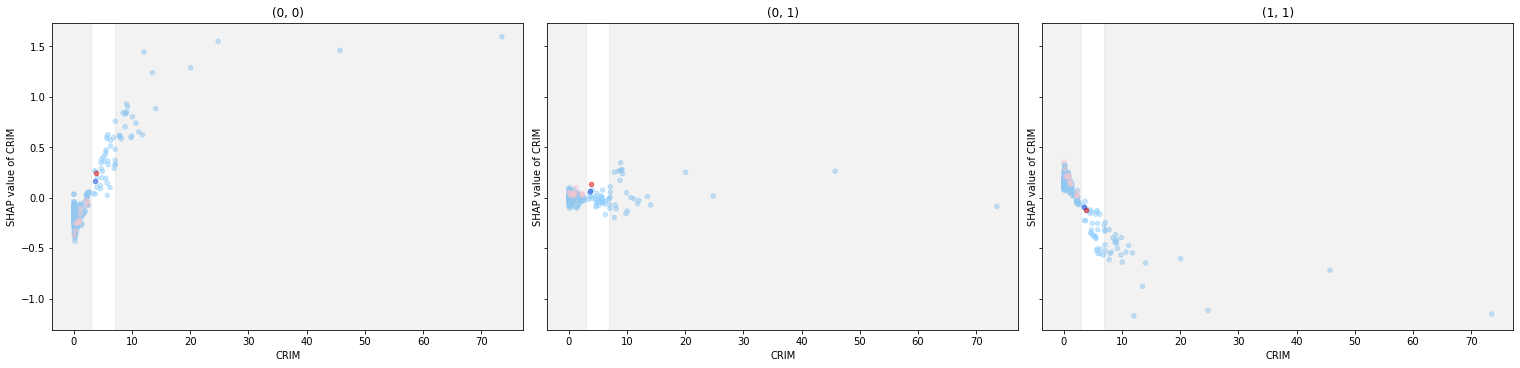

PTRATIO == 20.2
PTRATIO <= 16.71 --> {'(0, 0)': 1}
PTRATIO >= 20.74 --> {'(1, 1)': 1}


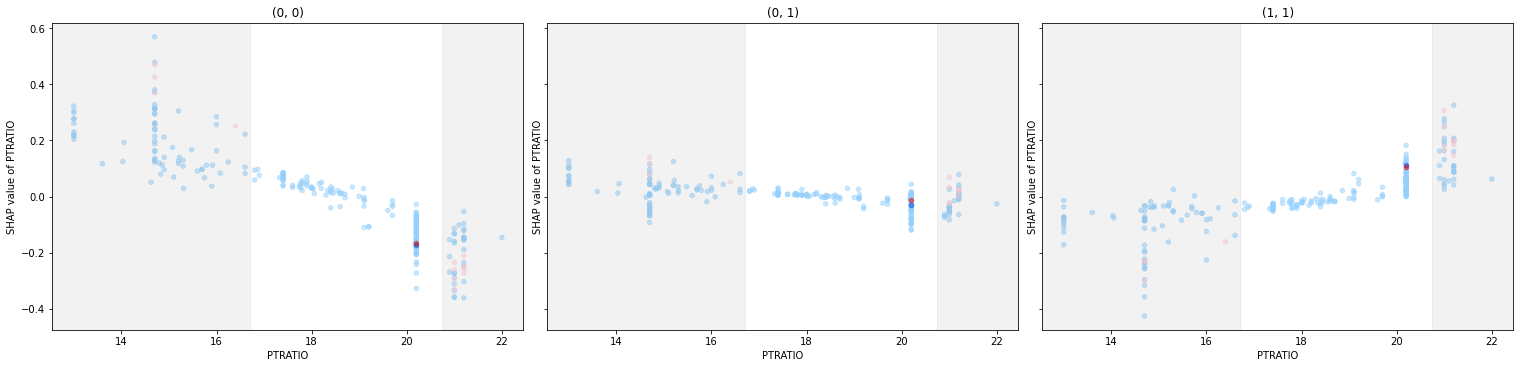

AGE == 2.0
AGE <= 1.0 --> {'(1, 1)': 1}


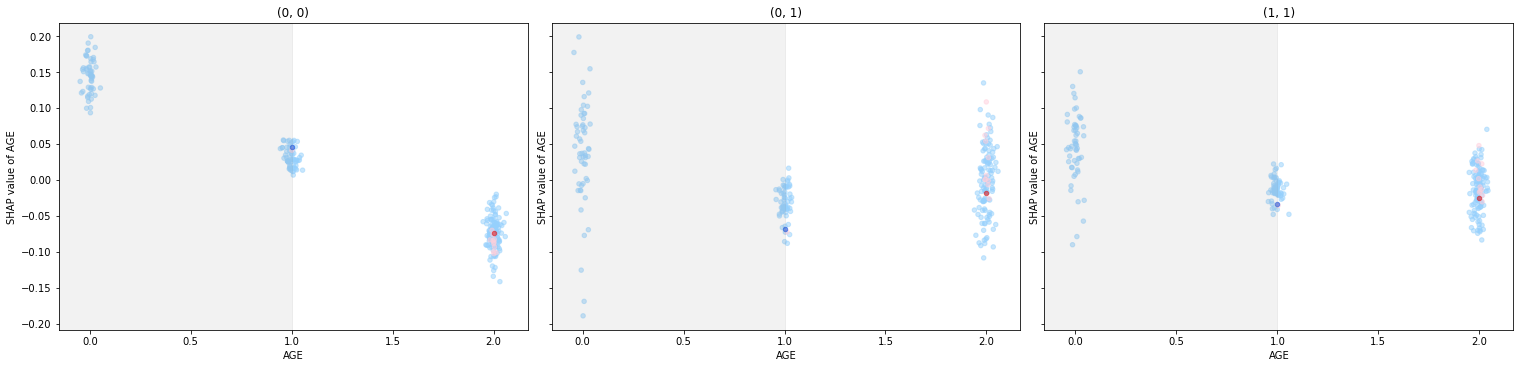

In [37]:
for feature in node.feature_names_relevant[:8]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

This instance has a particularly high TAX value. If it was 499 or lower, the prediction would flip.

Compared to the instance most similar, AGE is 2 instead of 1.

### Node RLRRRR

In [39]:
node = node.root.get('RLRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRR,
 (1, 1)    12
 (0, 1)    10
 (0, 0)     4
 dtype: int64,
 3.6105211202572907)

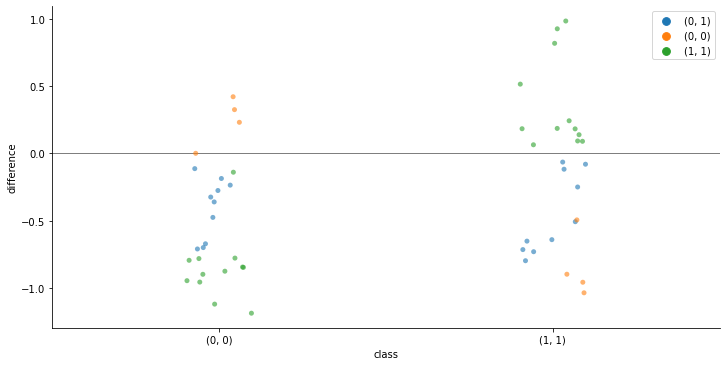

{'(0, 0)': '-0.71 to -0.11', '(1, 1)': '-0.8 to -0.06'}


In [40]:
node.plot_outcome_differences()

11.1 <= LSTAT <= 17.348228318163887
LSTAT <= 10.24 --> {'(1, 1)': 10}
LSTAT >= 19.17 --> {'(0, 0)': 10}


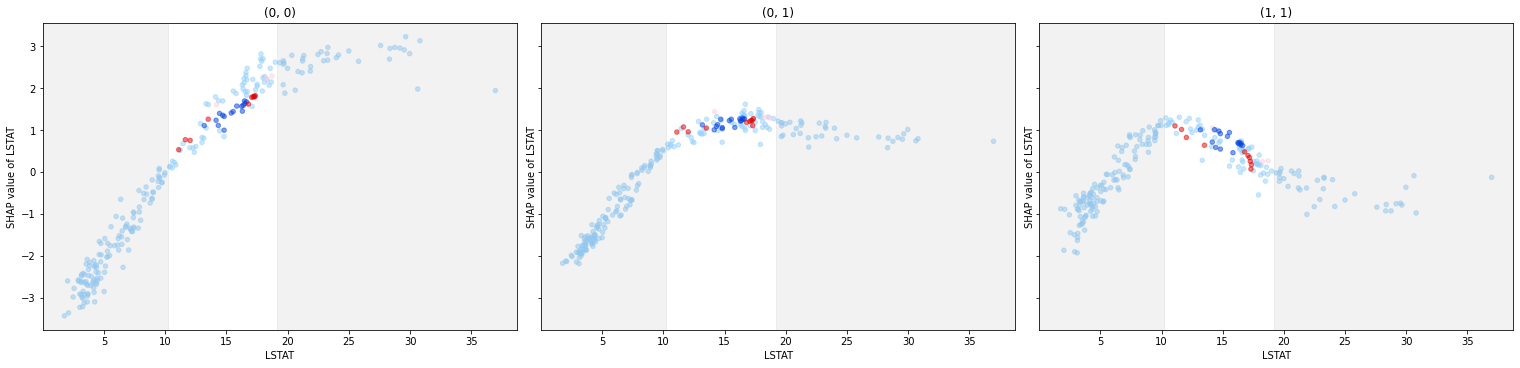

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 10}


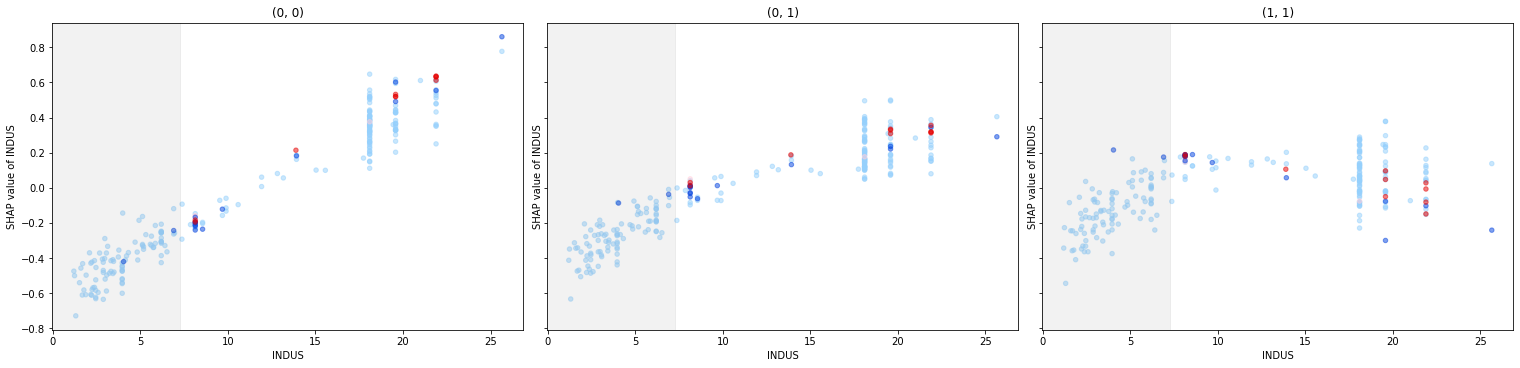

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 10}


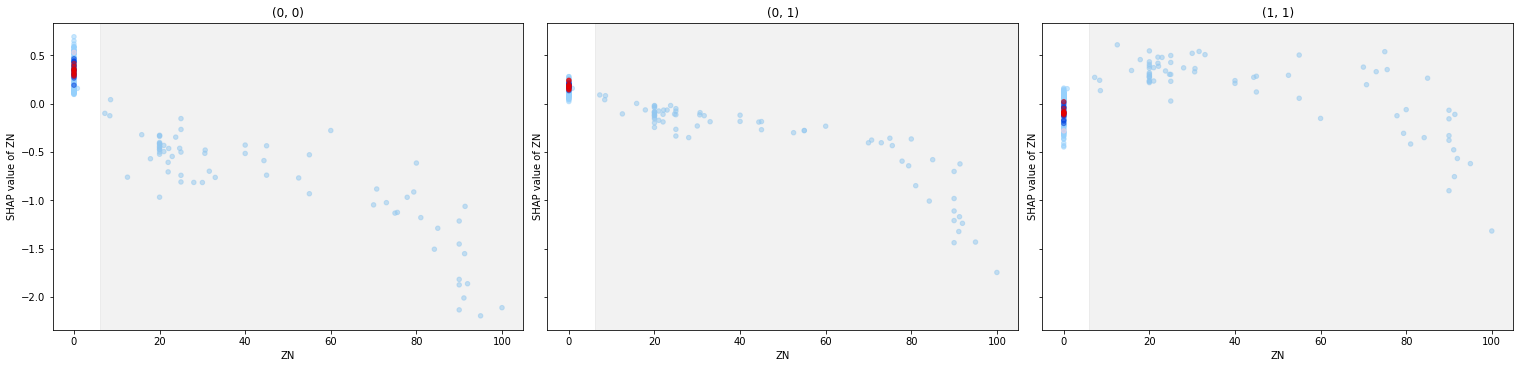

In [40]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

Interestingly, INDUS now has a counterfactual explanation, but it still covers the majority of the data.

### Node RLRRRRLL

In [41]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRLL,
 (0, 1)    3
 dtype: int64,
 0.16203184122485784)

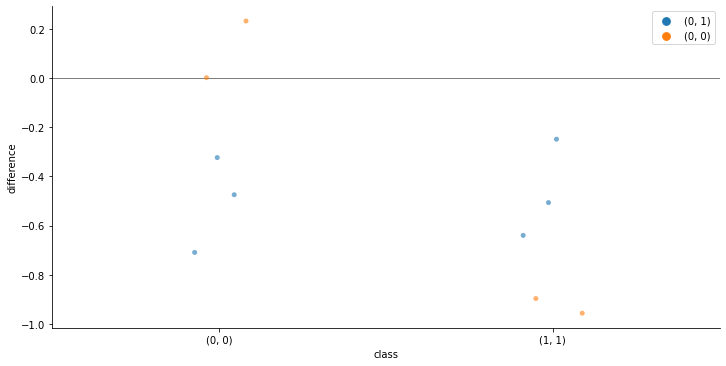

{'(0, 0)': '-0.71 to -0.32', '(1, 1)': '-0.64 to -0.25'}


In [42]:
node.get_parent().plot_outcome_differences()

11.1 <= LSTAT <= 12.03
LSTAT <= 10.24 --> {'(1, 1)': 3}
LSTAT >= 13.14 --> {'(0, 0)': 3}


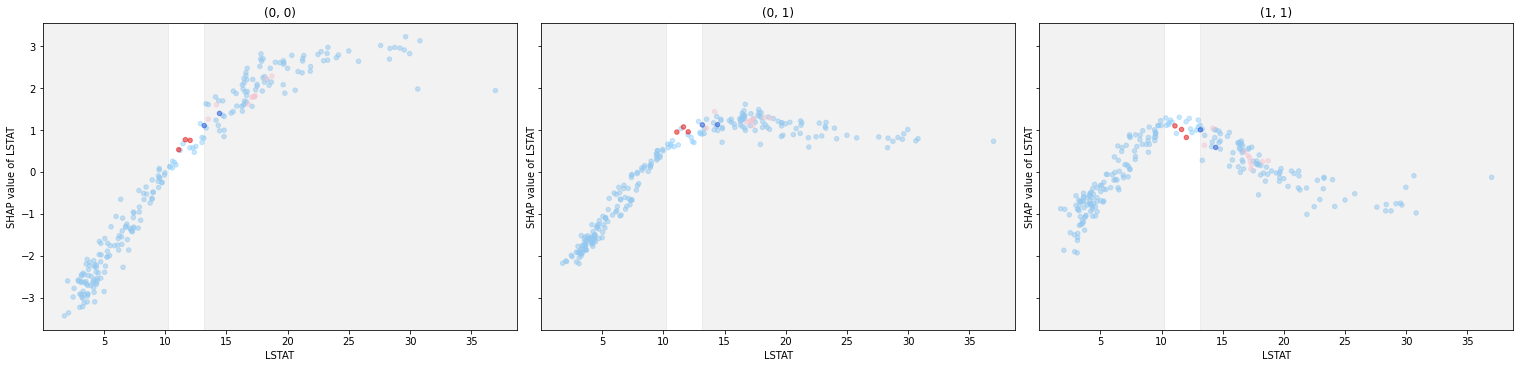

INDUS == 19.58
INDUS <= 12.03 --> {'(1, 1)': 3}


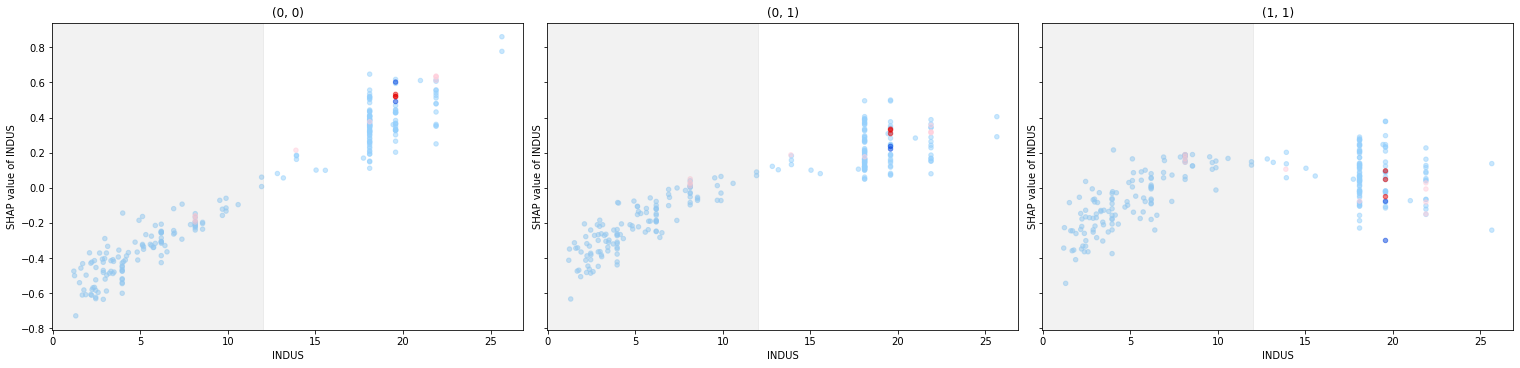

In [43]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

These instances have a high INDUS value. If it was 12.03 or lower, the prediction would flip to $(1,1)$.

Most significantly, a higher LSTAT flips the prediction to $(0,0)$, similar to the comparison instances.

### Node RLRRRRR

In [45]:
node = node.root.get('RLRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRR,
 (1, 1)    12
 (0, 1)     7
 (0, 0)     2
 dtype: int64,
 2.8788266439832437)

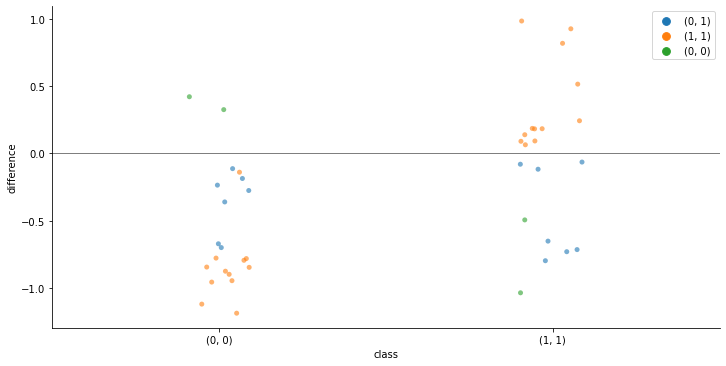

{'(0, 0)': '-0.7 to -0.11', '(1, 1)': '-0.8 to -0.06'}


In [46]:
node.plot_outcome_differences()

13.51 <= LSTAT <= 17.348228318163887
LSTAT <= 13.14 --> {'(1, 1)': 7}
LSTAT >= 19.17 --> {'(0, 0)': 7}


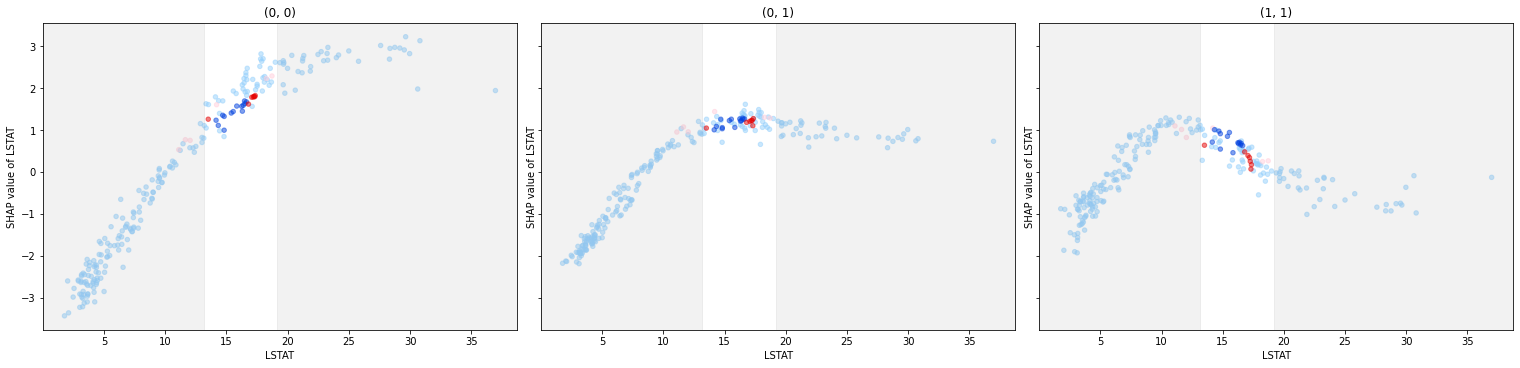

8.14 <= INDUS <= 21.89
INDUS <= 7.25 --> {'(1, 1)': 7}


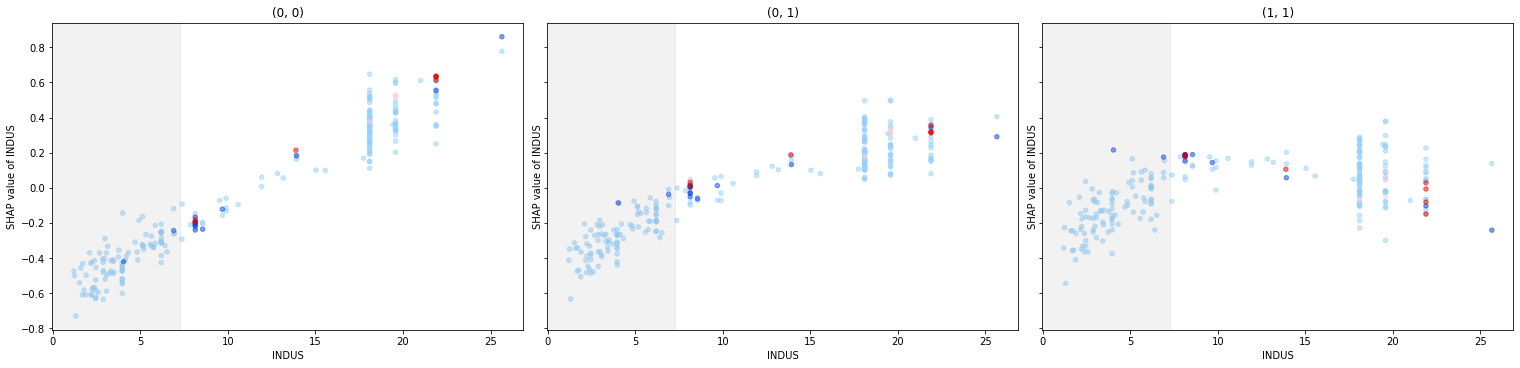

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 7}


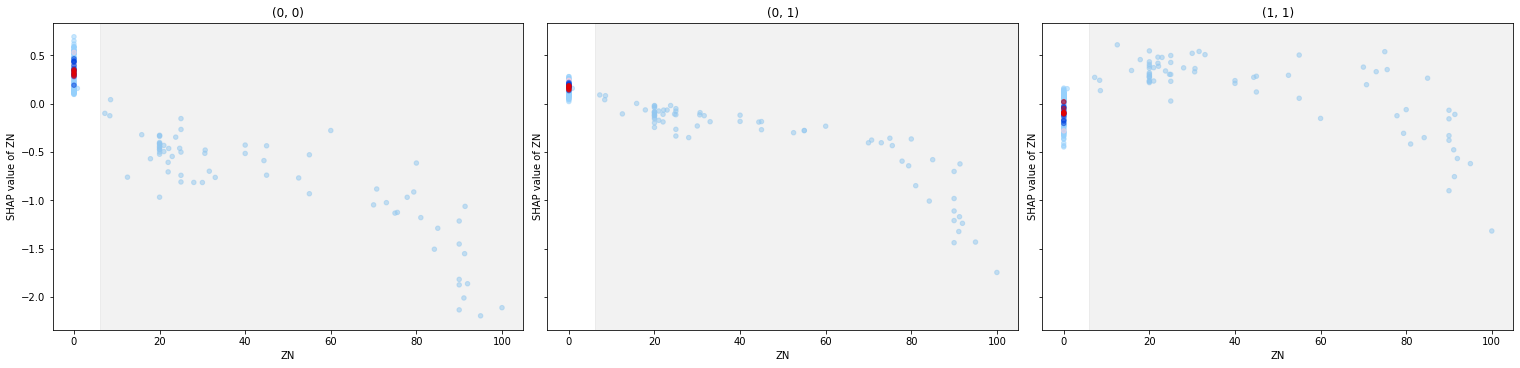

In [46]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

INDUS does not offer a satisfying counterfactual explanation, which might be due to the high range of INDUS values present in instances classified differently. I will investigate on a lower hierarchy level.

### Node RLRRRRRLLL

In [47]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRRLLL,
 (0, 1)    2
 dtype: int64,
 0.05363359285917131)

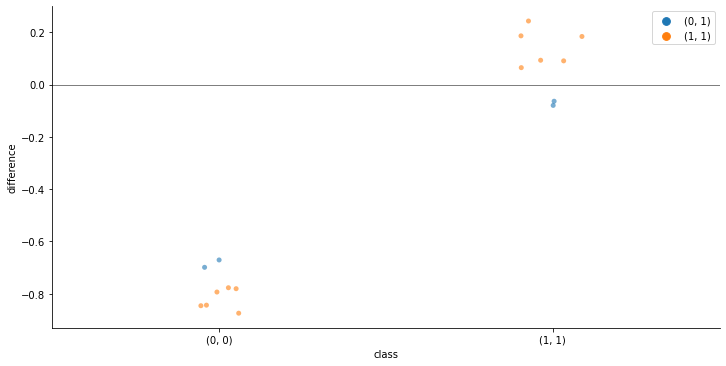

{'(0, 0)': '-0.7 to -0.67', '(1, 1)': '-0.08 to -0.06'}


In [48]:
node.get_parent().plot_outcome_differences()

16.79698376047181 <= LSTAT <= 17.066695066513088
LSTAT <= 16.63 --> {'(1, 1)': 2}
LSTAT >= 19.17 --> {'(0, 0)': 2}


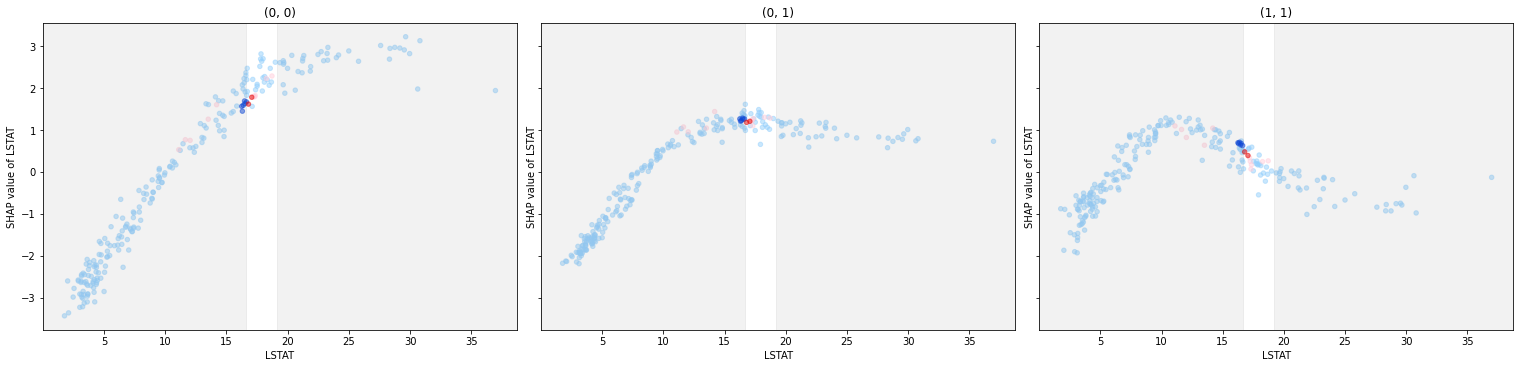

TAX == 307.0
TAX >= 324.0 --> {'(1, 1)': 2}


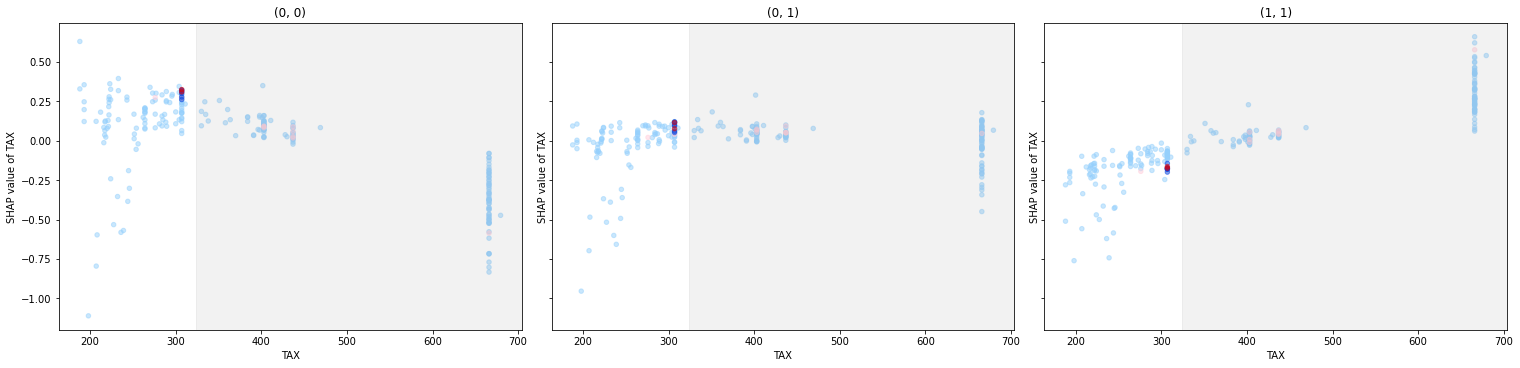

ZN == 0.0
ZN >= 1.0 --> {'(1, 1)': 2}


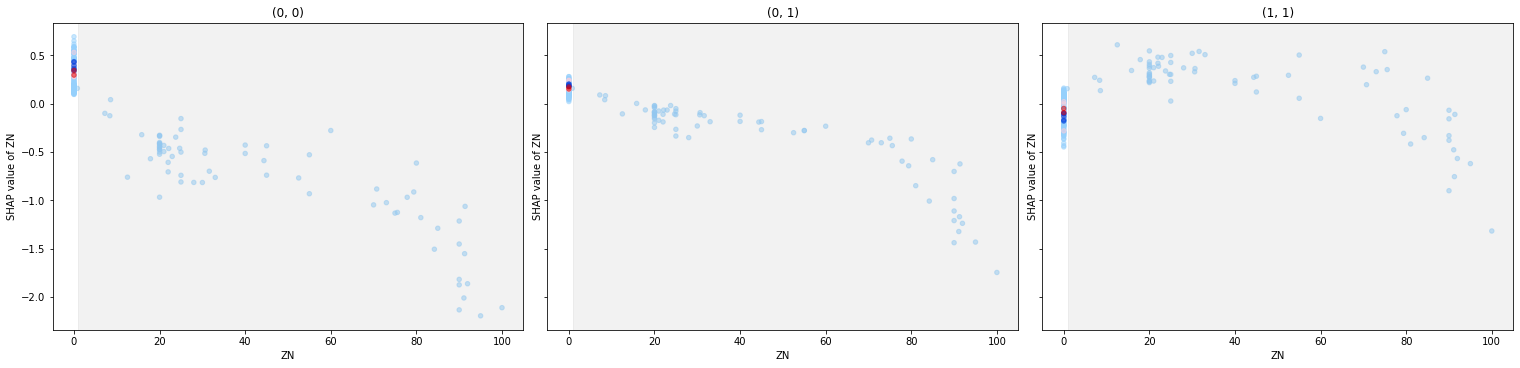

In [49]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

For these instances, the counterfactual for ZN is much lower and the lowest possible CRIM value actually flips the prediction to $(1,1)$.

LSTAT lower counterfactual separates the groups well.

### Node RLRRRRRR

In [50]:
node = node.root.get('RLRRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRRR,
 (0, 1)    5
 (0, 0)    2
 (1, 1)    1
 dtype: int64,
 1.4070206110764154)

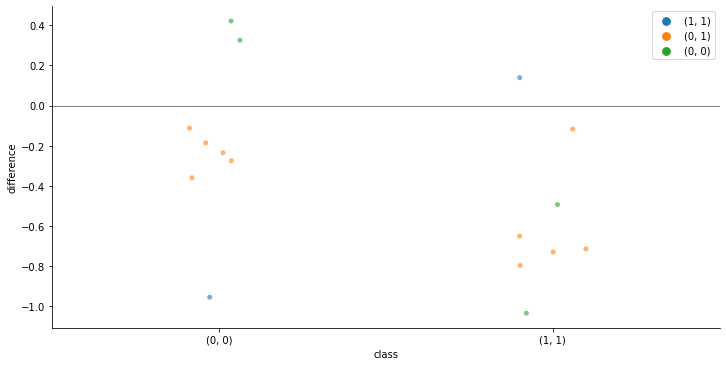

{'(0, 0)': '-0.36 to -0.11', '(1, 1)': '-0.8 to -0.12'}


In [51]:
node.plot_outcome_differences()

13.51 <= LSTAT <= 17.348228318163887
LSTAT <= 13.14 --> {'(1, 1)': 5}
LSTAT >= 18.14 --> {'(0, 0)': 5}


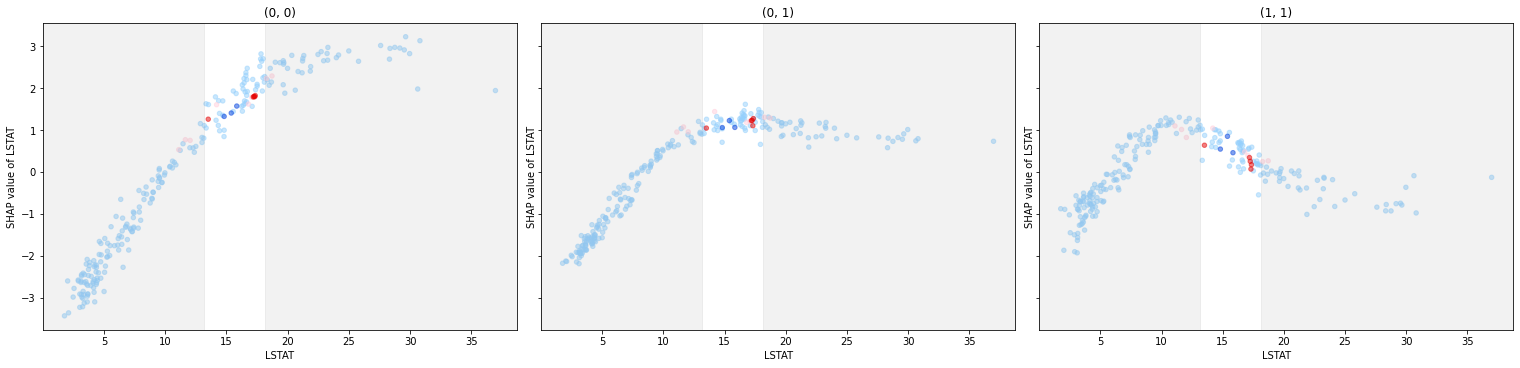

13.89 <= INDUS <= 21.89
INDUS <= 11.88 --> {'(1, 1)': 5}


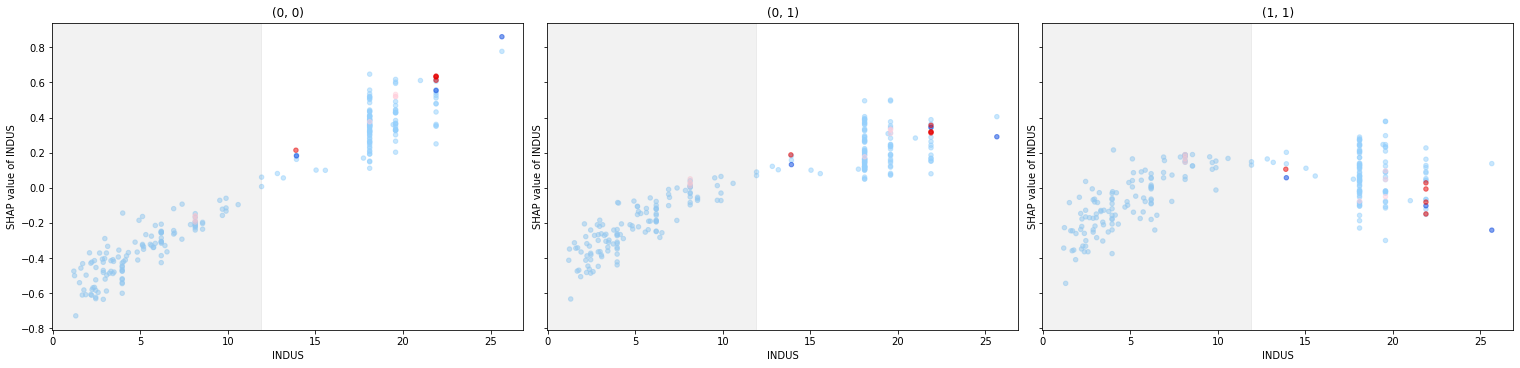

ZN <= 0.0
ZN >= 6.0 --> {'(1, 1)': 5}


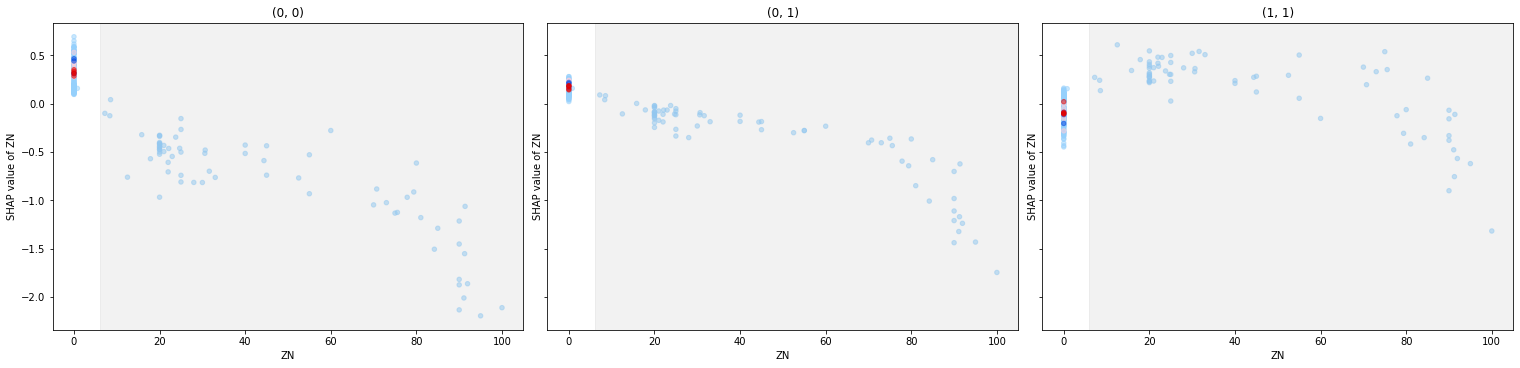

In [52]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

INDUS is ranked as the second most important feature in this cluster. But still it seems to have structure: some with lower values and some with higher.

### Node RLRRRRRRLR

In [52]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRRRLR,
 (0, 1)    4
 dtype: int64,
 0.1578406317335593)

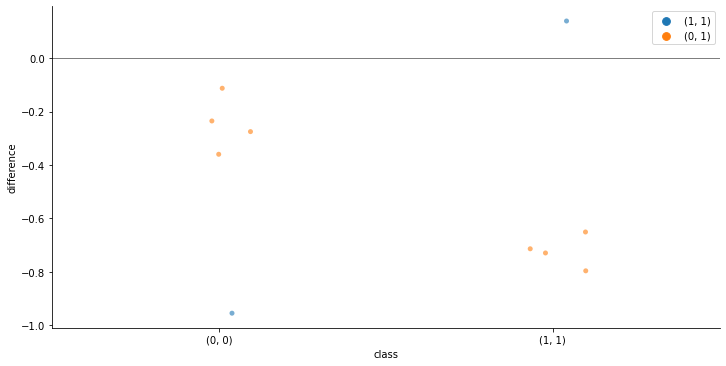

{'(0, 0)': '-0.36 to -0.11', '(1, 1)': '-0.8 to -0.65'}


In [60]:
node.get_parent().plot_outcome_differences()

17.19 <= LSTAT <= 17.348228318163887
LSTAT <= 14.9 --> {'(1, 1)': 4}
LSTAT >= 18.14 --> {'(0, 0)': 4}


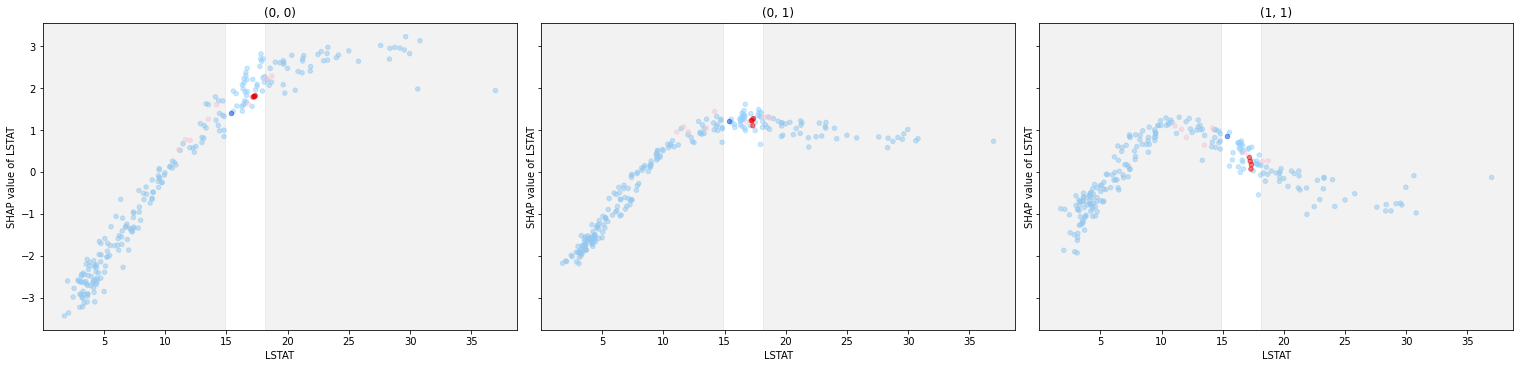

INDUS == 21.89
INDUS <= 11.88 --> {'(1, 1)': 4}


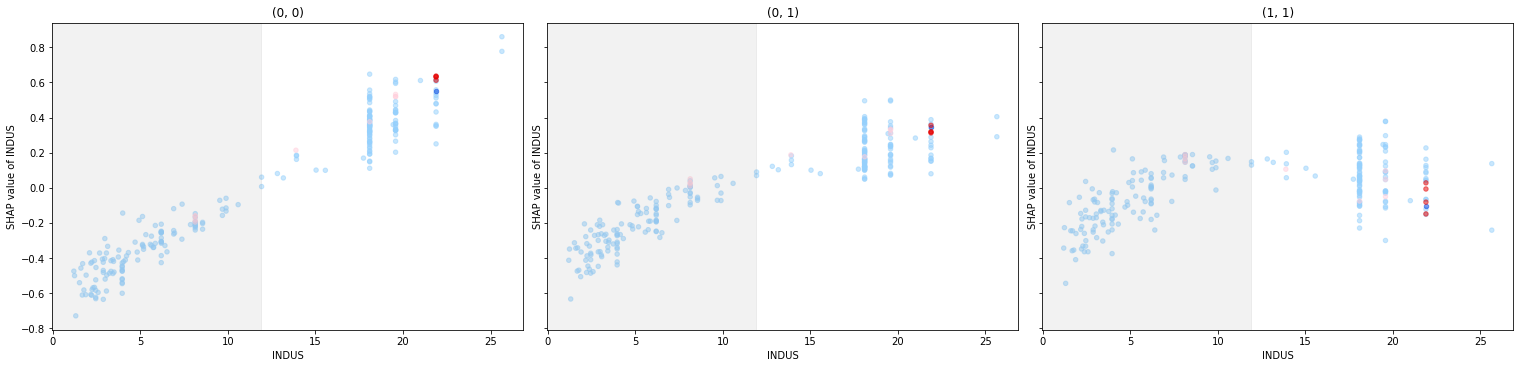

ZN == 0.0
ZN >= 6.0 --> {'(1, 1)': 4}


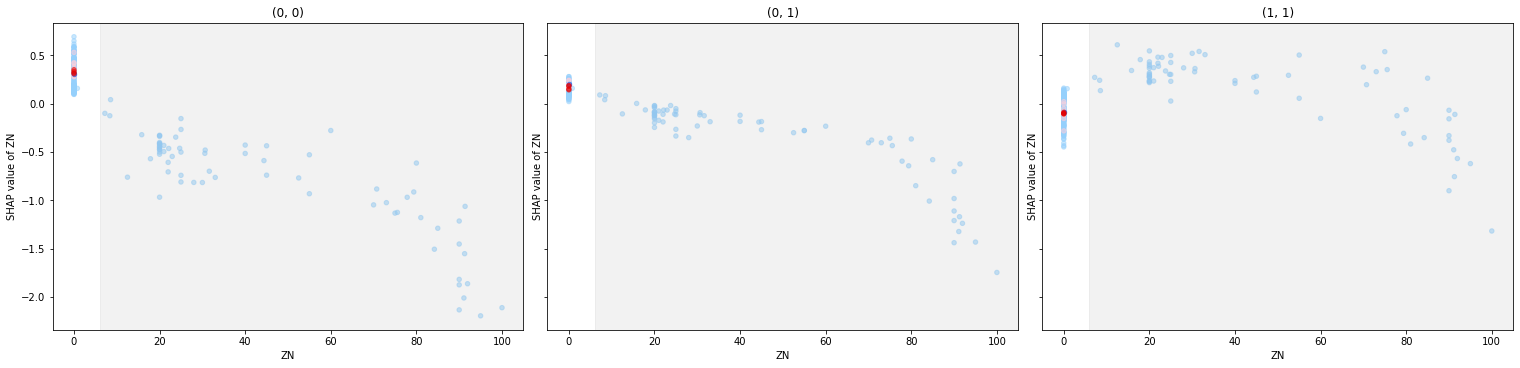

PTRATIO == 21.2
PTRATIO <= 19.53 --> {'(0, 0)': 4}


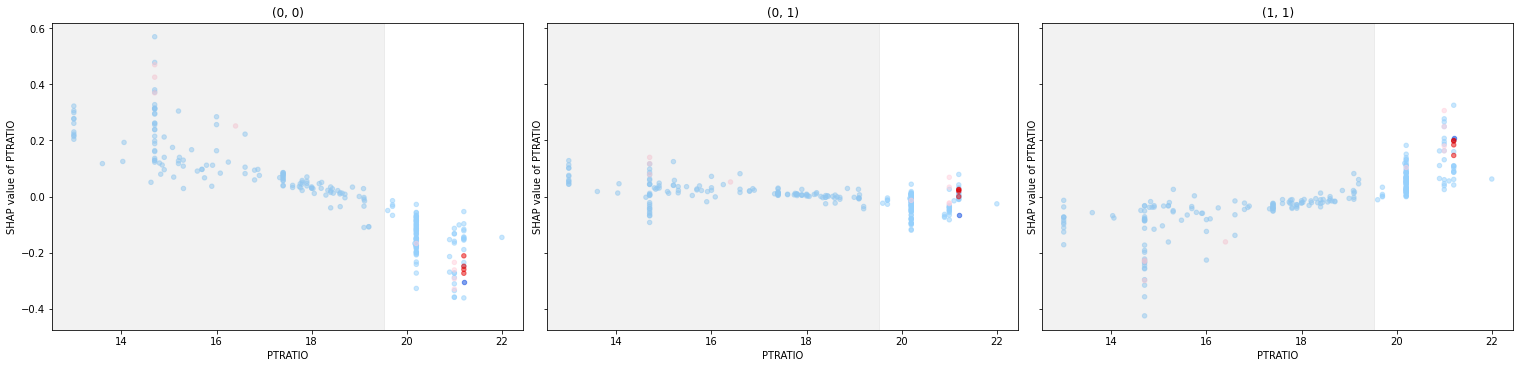

0.25915 <= CRIM <= 0.97617
CRIM >= 2.0 --> {'(0, 0)': 4}


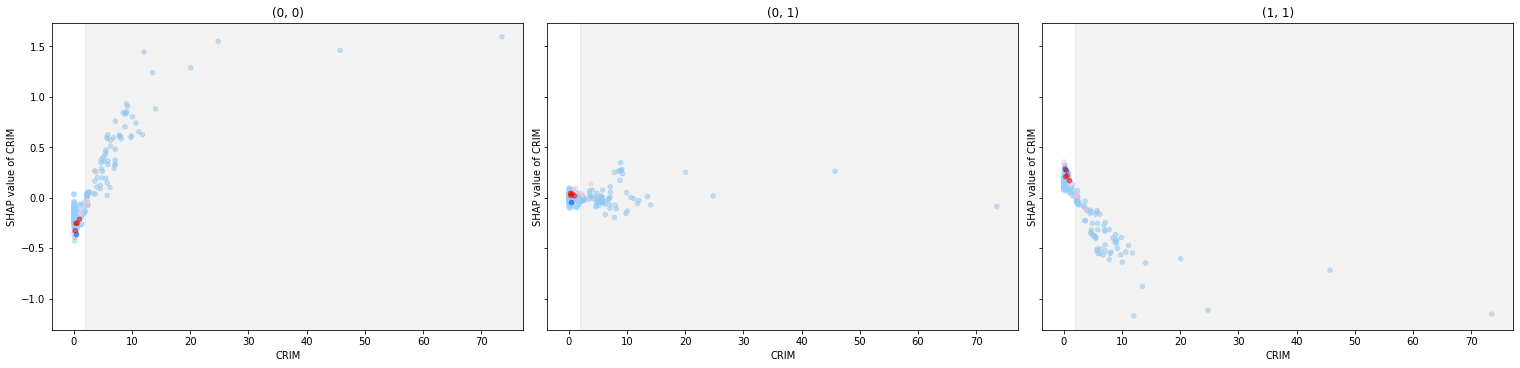

5.685294968854628 <= RM <= 5.757
RM <= 3.93 --> {'(0, 0)': 4}


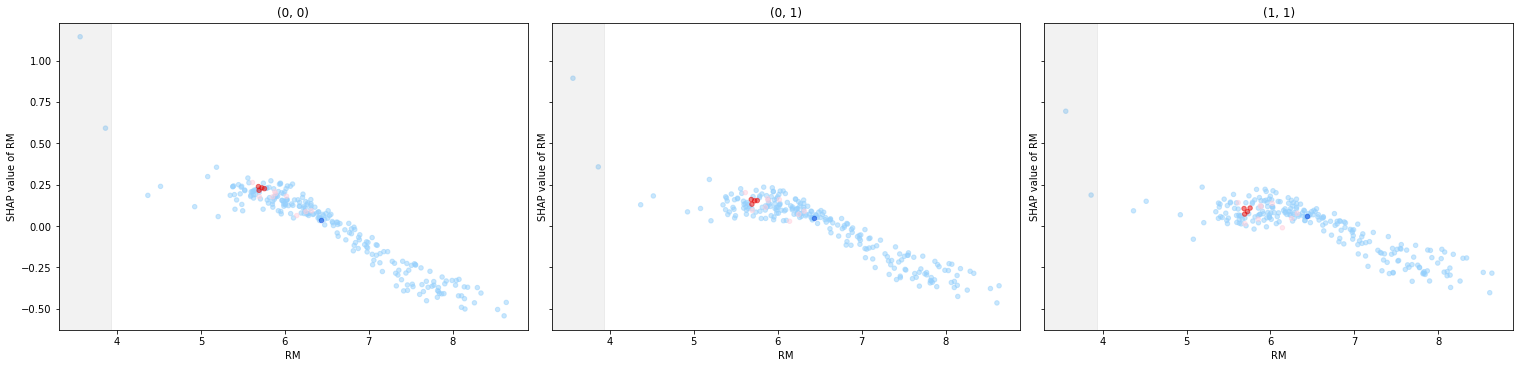

AGE == 2.0
AGE <= 1.0 --> {'(0, 0)': 4}


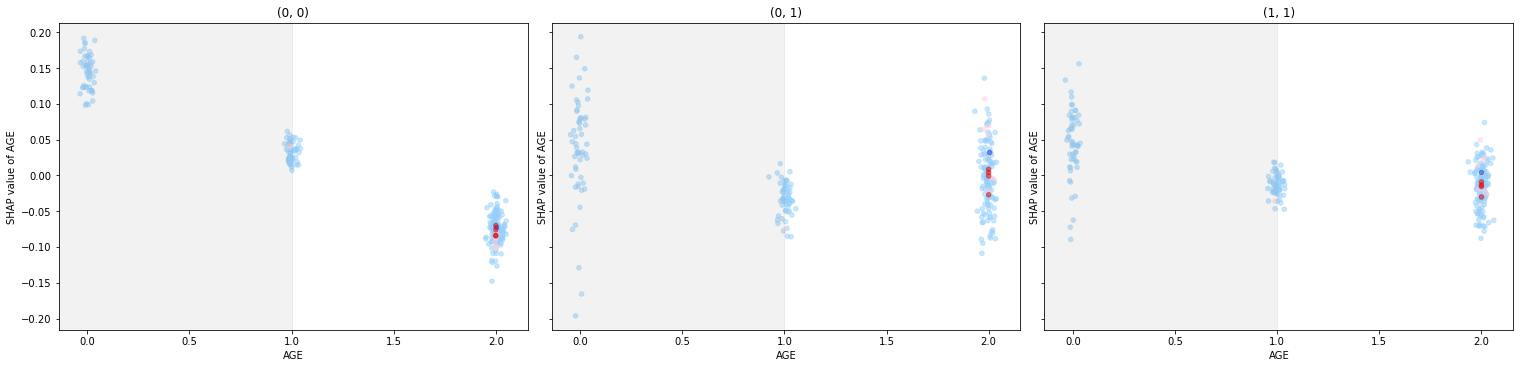

RAD == 4.0
RAD >= 12.41 --> {'(0, 0)': 4}


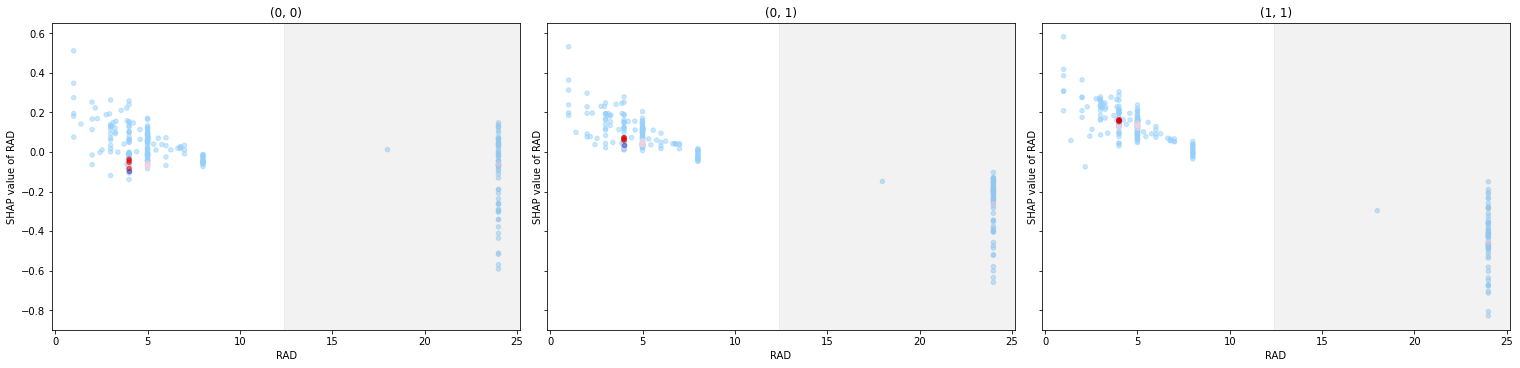

TAX == 437.0
TAX <= 353.0 --> {'(0, 0)': 4}
TAX >= 619.0 --> {'(1, 1)': 4}


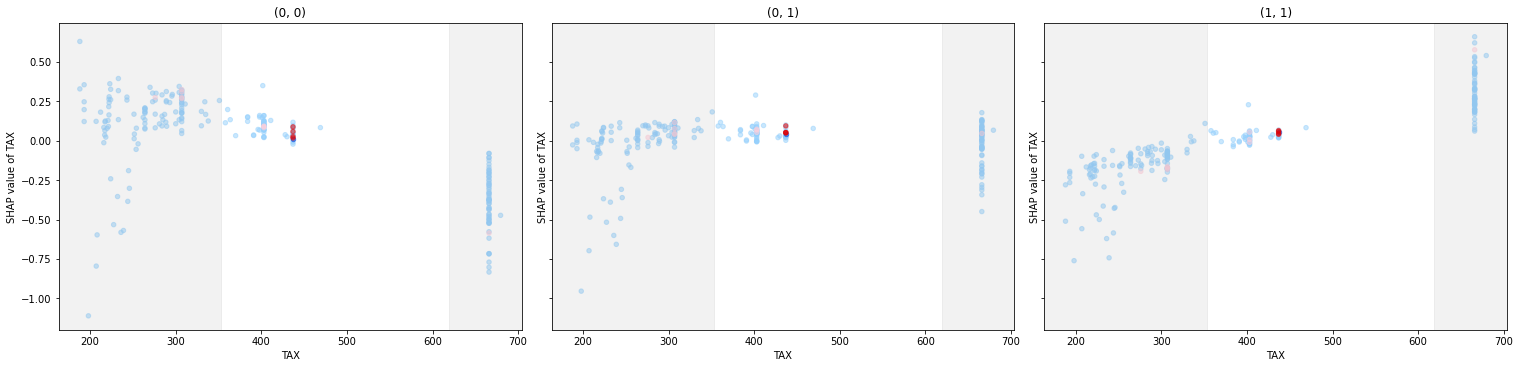

In [59]:
for feature in node.feature_names_relevant[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

Interestingly, the children are split by INDUS. This cluster has the same counterfactual as the parent cluster.

Upper counterfactual of LSTAT is most significant, despite no comparison instances are there.

### Node RLRRRRRRRRR

In [61]:
node = node.root.get('RLRRRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRRRRRRR,
 (0, 1)    1
 dtype: int64,
 0)

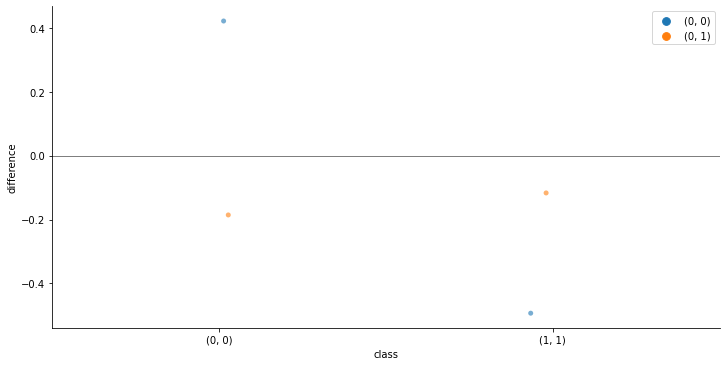

{'(0, 0)': '-0.19 to -0.19', '(1, 1)': '-0.12 to -0.12'}


In [62]:
node.get_parent().plot_outcome_differences()

LSTAT == 13.51
LSTAT <= 13.14 --> {'(1, 1)': 1}
LSTAT >= 14.1 --> {'(0, 0)': 1}


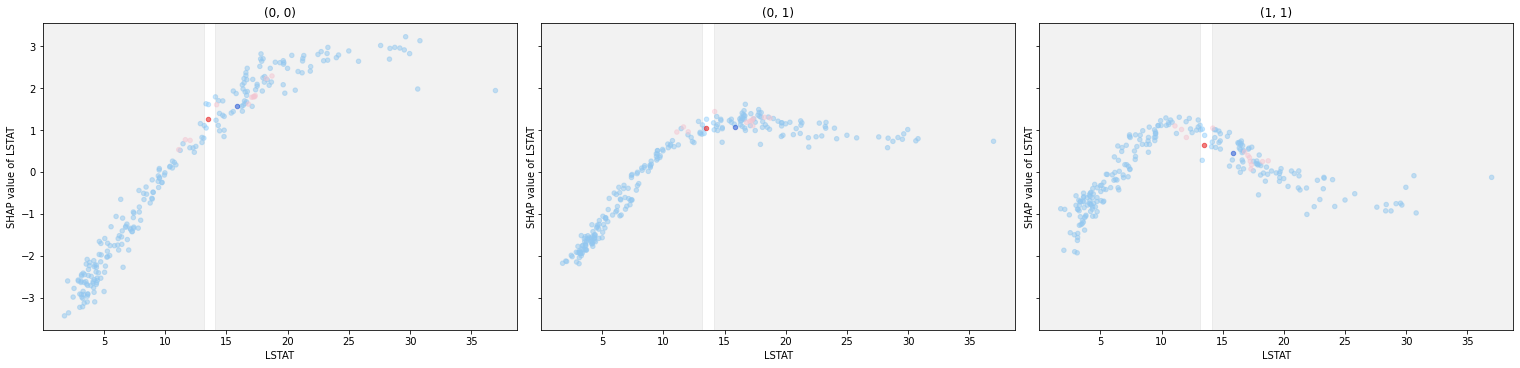

CRIM == 0.0456
CRIM >= 1.0 --> {'(0, 0)': 1}


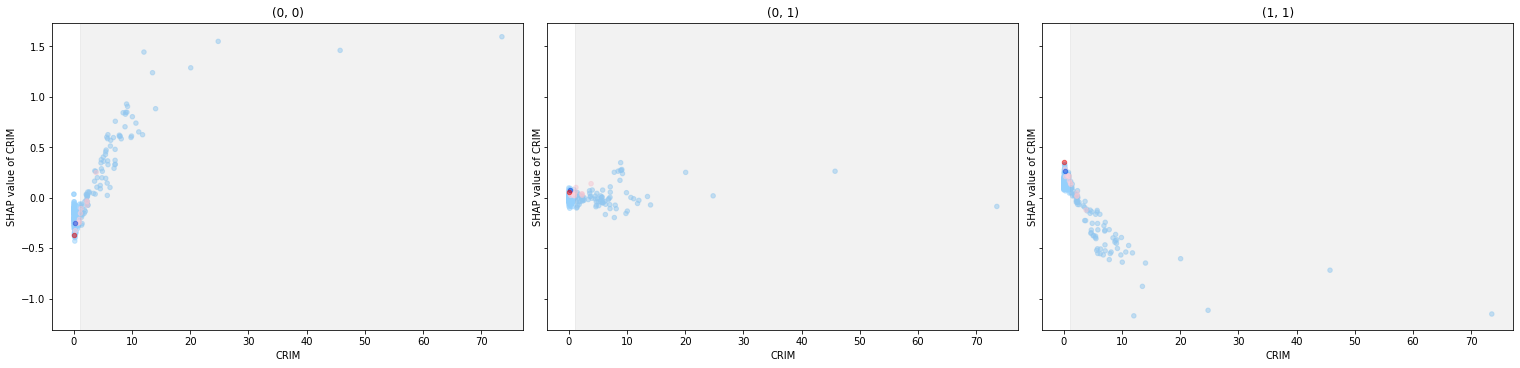

In [63]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

For this instance, there is even an upper counterfactual.

## Clustering of Class $(1,2)$ SHAP Values

In [64]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(1, 2)', ['(1, 1)', '(1, 2)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 1.32 s, sys: 17.6 ms, total: 1.34 s
Wall time: 1.37 s


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 59.55960394852703)

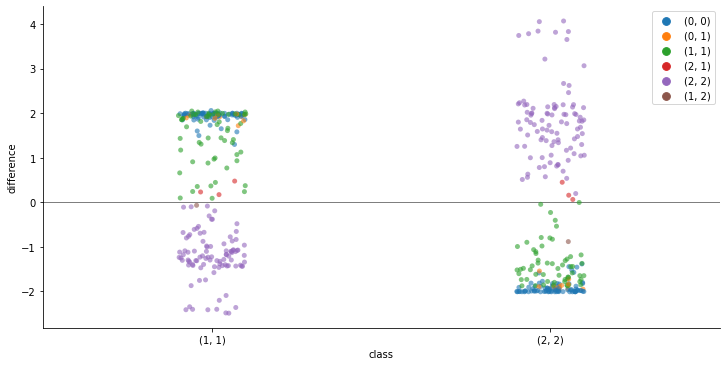

{'(1, 1)': '-0.07 to -0.07', '(2, 2)': '-0.88 to -0.88'}


In [65]:
node.plot_outcome_differences()

### Node RLRRRLL

In [66]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRRRLL,
 (1, 2)    1
 dtype: int64,
 0)

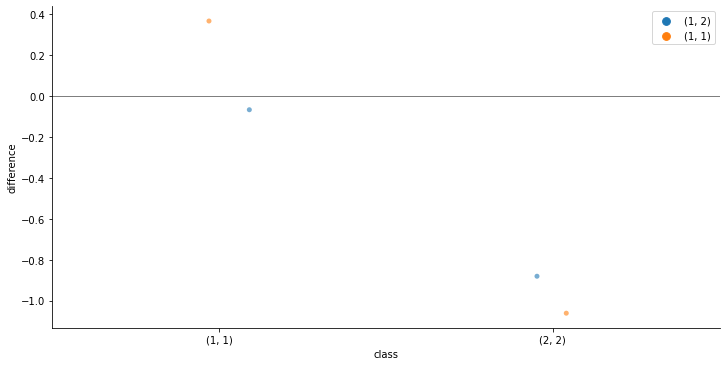

{'(1, 1)': '-0.07 to -0.07', '(2, 2)': '-0.88 to -0.88'}


In [67]:
node.get_parent().plot_outcome_differences()

LSTAT == 6.15
LSTAT <= 4.51 --> {'(2, 2)': 1}
LSTAT >= 6.28 --> {'(1, 1)': 1}


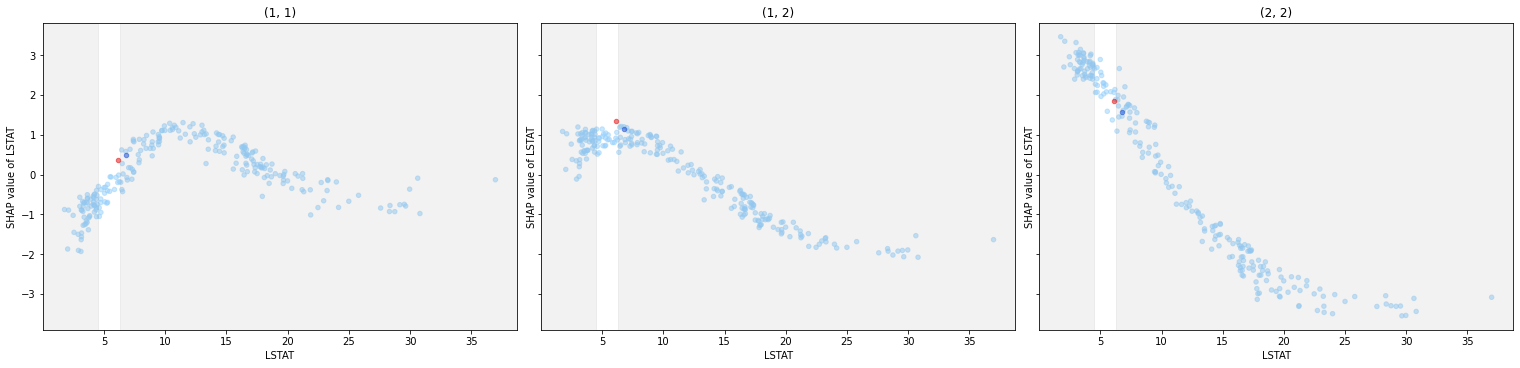

DIS == 5.4159
DIS <= 1.9 --> {'(2, 2)': 1}
DIS >= 5.66 --> {'(1, 1)': 1}


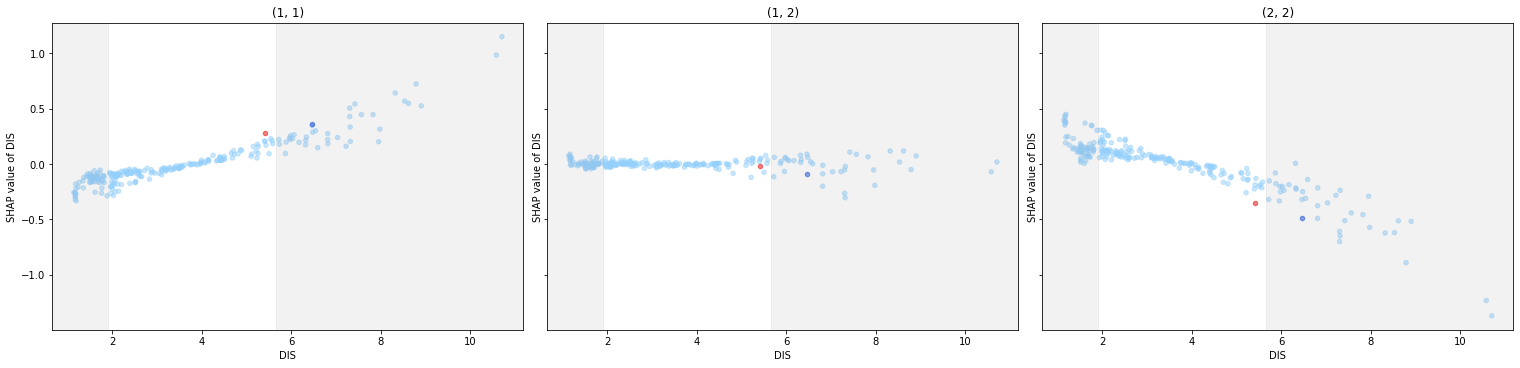

In [69]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

These are the explanations for the locally most important features.

## Clustering of Class $(2,1)$ SHAP Values

In [95]:
%%time
node = make_clustering(comparer, diffclf_shap_values,
                       '(2, 1)', ['(1, 1)', '(2, 1)', '(2, 2)'],
                       categorical_features=categorical_features,
                       feature_precisions=feature_precisions)
node.class_counts, node.distance

CPU times: user 581 ms, sys: 6.84 ms, total: 587 ms
Wall time: 596 ms


((2, 2)    95
 (0, 0)    76
 (1, 1)    58
 (0, 1)    13
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 60.777823506026564)

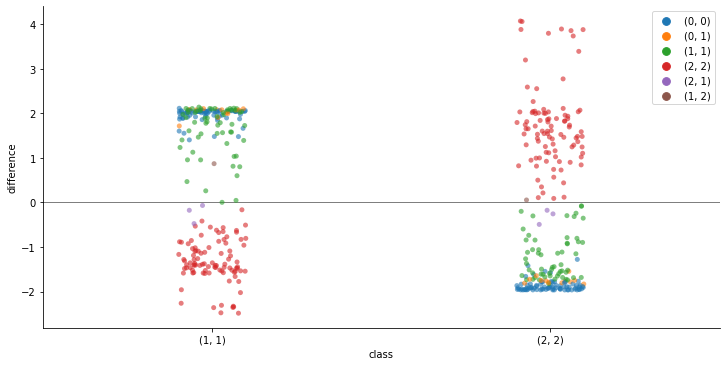

{'(1, 1)': '-0.47 to -0.07', '(2, 2)': '-0.49 to -0.18'}


In [71]:
node.plot_outcome_differences()

### Node RRR

In [96]:
node = node.root.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRR,
 (1, 1)    20
 (2, 2)    10
 (2, 1)     3
 (1, 2)     1
 dtype: int64,
 11.142325438034494)

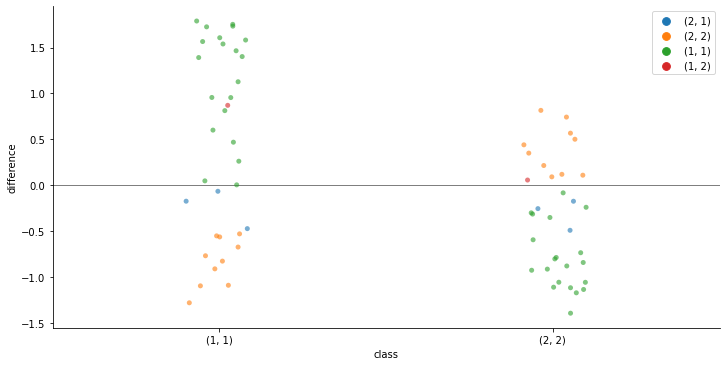

{'(1, 1)': '-0.47 to -0.07', '(2, 2)': '-0.49 to -0.18'}


In [73]:
node.plot_outcome_differences()

6.48 <= LSTAT <= 8.93
LSTAT <= 5.97 --> {'(2, 2)': 3}
LSTAT >= 9.06 --> {'(1, 1)': 3}


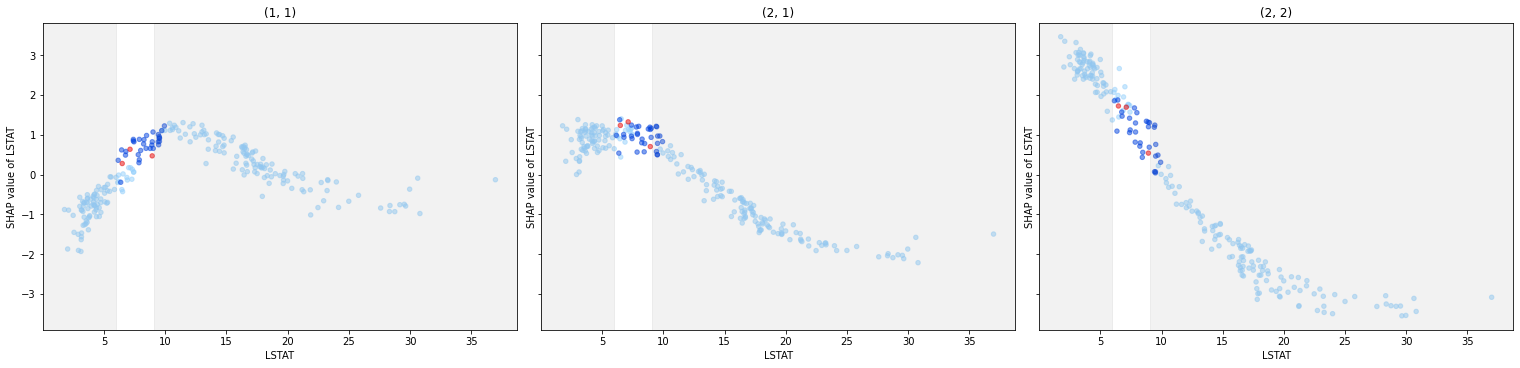

2.18 <= INDUS <= 18.1
INDUS >= 19.62 --> {'(1, 1)': 3}


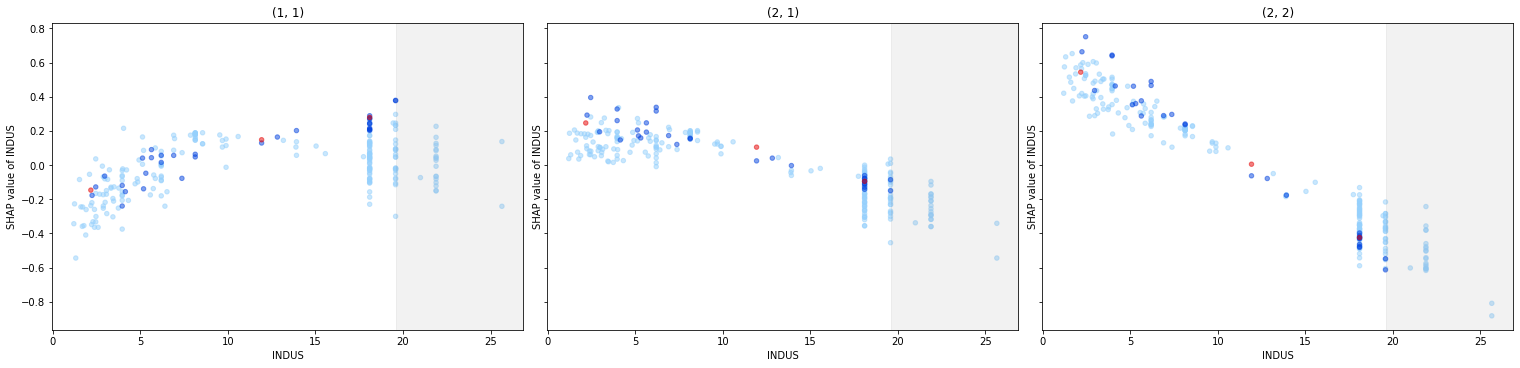

ZN <= 33.0
ZN >= 82.0 --> {'(2, 2)': 3}


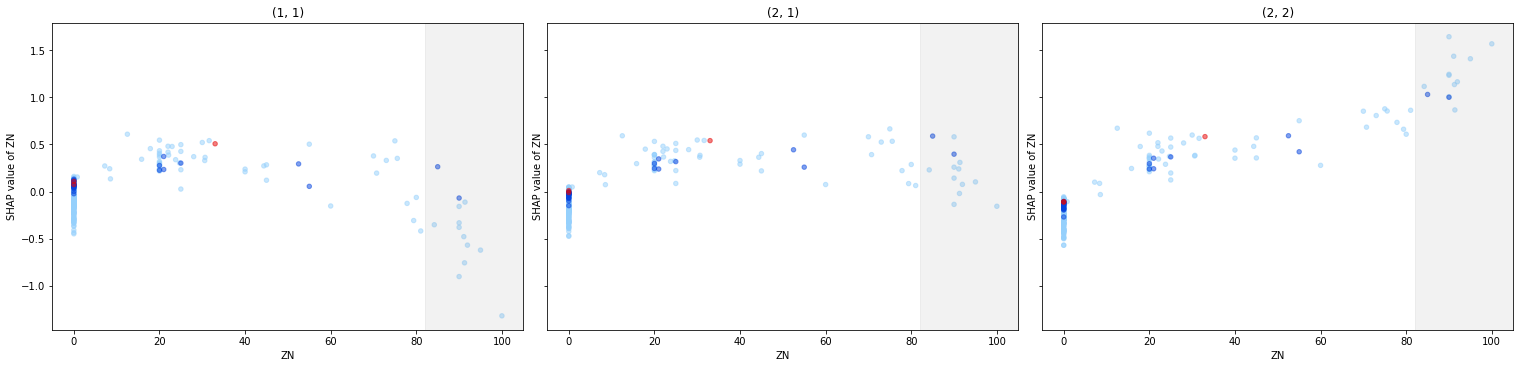

In [74]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RRRLL

In [99]:
node = node.root.get('RRRL').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRLL,
 (2, 1)    1
 dtype: int64,
 0)

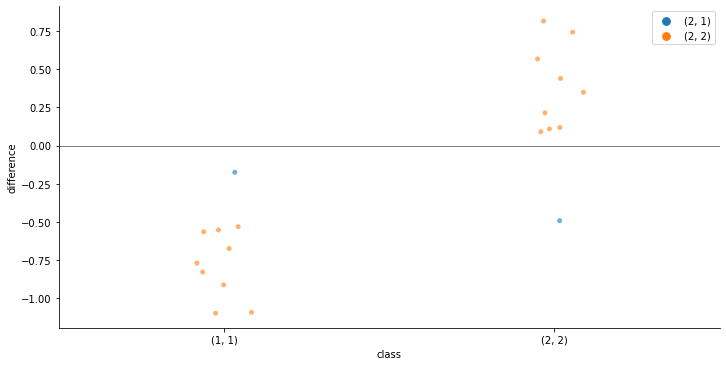

{'(1, 1)': '-0.17 to -0.17', '(2, 2)': '-0.49 to -0.49'}


In [76]:
node.get_parent().plot_outcome_differences()

LSTAT == 7.12
LSTAT <= 6.18 --> {'(2, 2)': 1}
LSTAT >= 7.42 --> {'(1, 1)': 1}


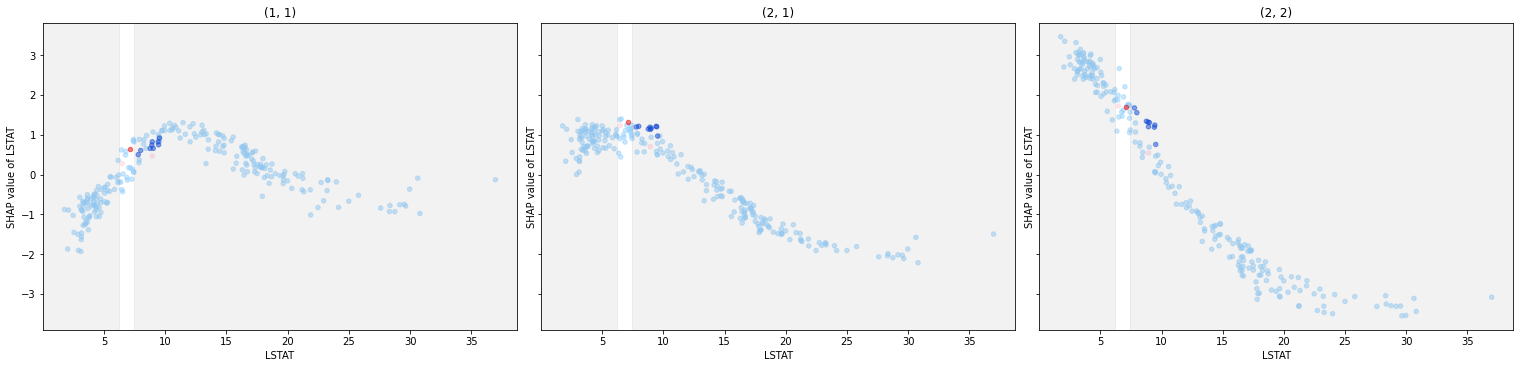

RM == 3.561
RM >= 4.36 --> {'(2, 2)': 1}


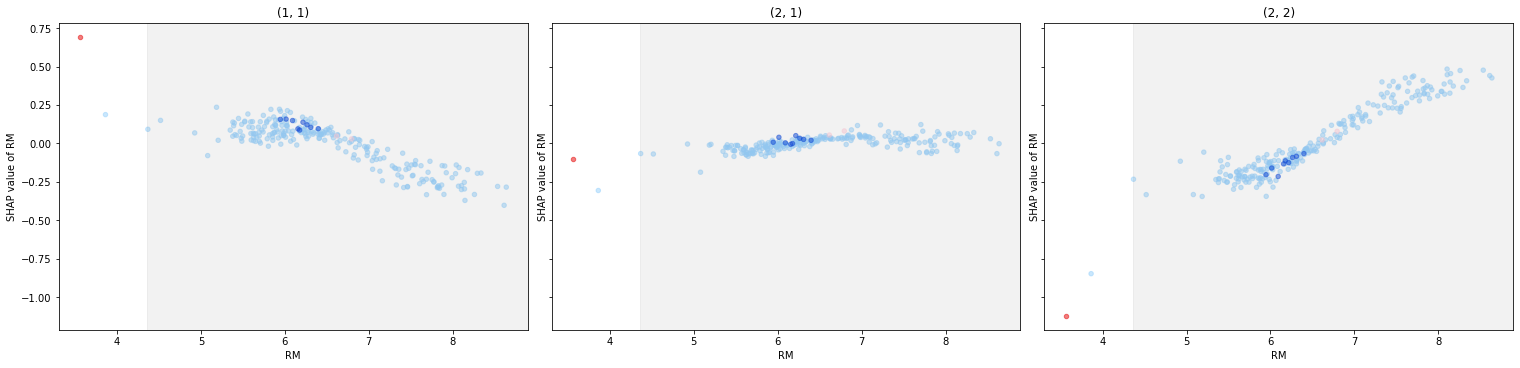

In [79]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

- LSTAT higher -> $(1,1)$ in contrast to comparison group which are $(2,2)$
- Outlier in terms of RM; higher -> $(2,2)$

### Node RRRRR

In [105]:
node = node.root.get('RRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRR,
 (1, 1)    13
 (2, 1)     2
 (2, 2)     1
 (1, 2)     1
 dtype: int64,
 5.33138660542534)

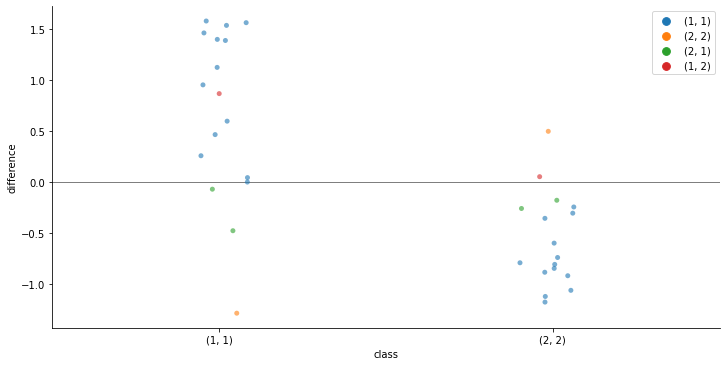

{'(1, 1)': '-0.47 to -0.07', '(2, 2)': '-0.26 to -0.18'}


In [106]:
node.plot_outcome_differences()

6.48 <= LSTAT <= 8.93
LSTAT <= 5.97 --> {'(2, 2)': 2}
LSTAT >= 9.06 --> {'(1, 1)': 2}


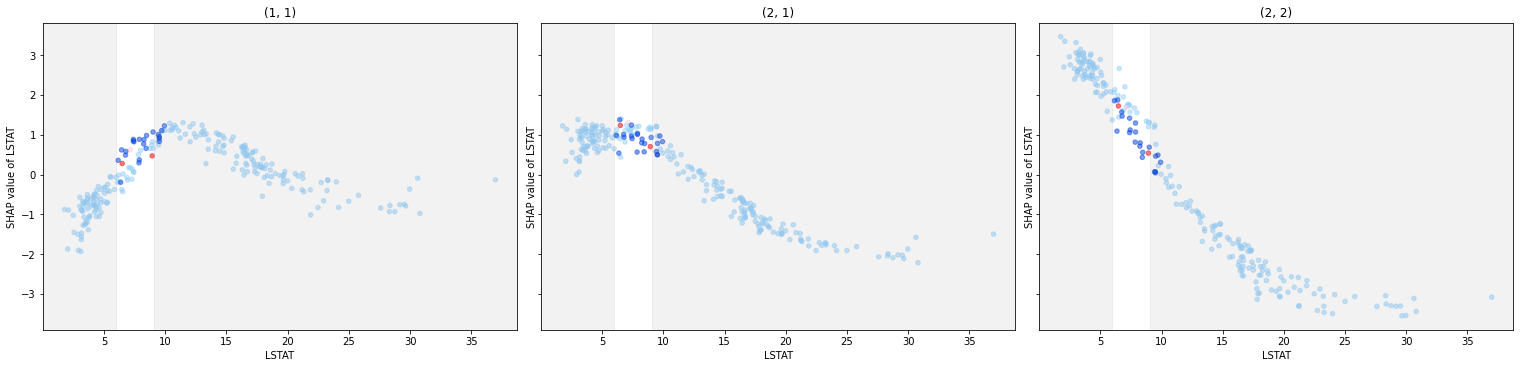

2.18 <= INDUS <= 11.93
INDUS >= 16.32 --> {'(1, 1)': 2}


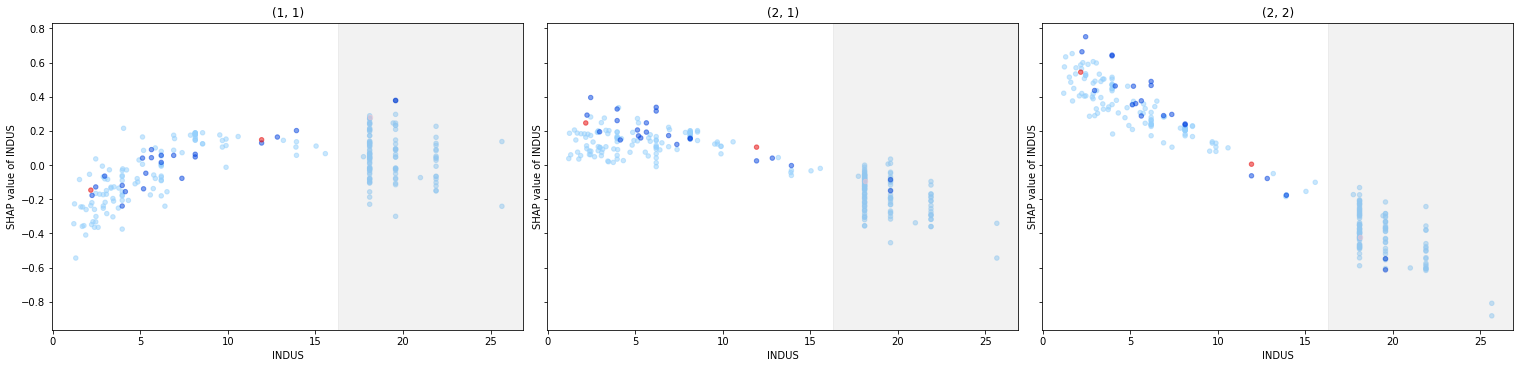

In [107]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

### Node RRRRRLRRR

In [108]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRLRRR,
 (2, 1)    1
 dtype: int64,
 0)

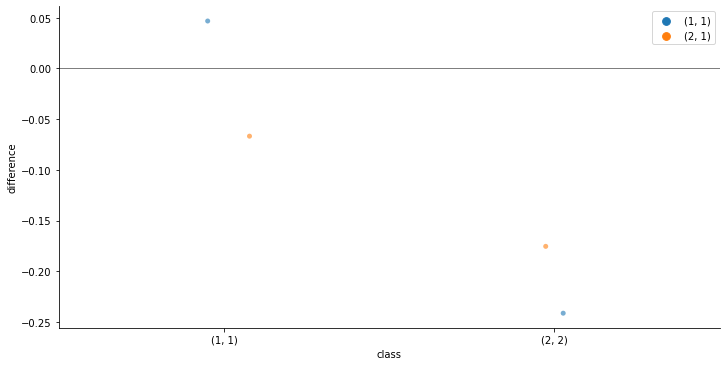

{'(1, 1)': '-0.07 to -0.07', '(2, 2)': '-0.18 to -0.18'}


In [109]:
node.get_parent().plot_outcome_differences()

LSTAT == 8.93
LSTAT <= 8.55 --> {'(2, 2)': 1}
LSTAT >= 9.06 --> {'(1, 1)': 1}


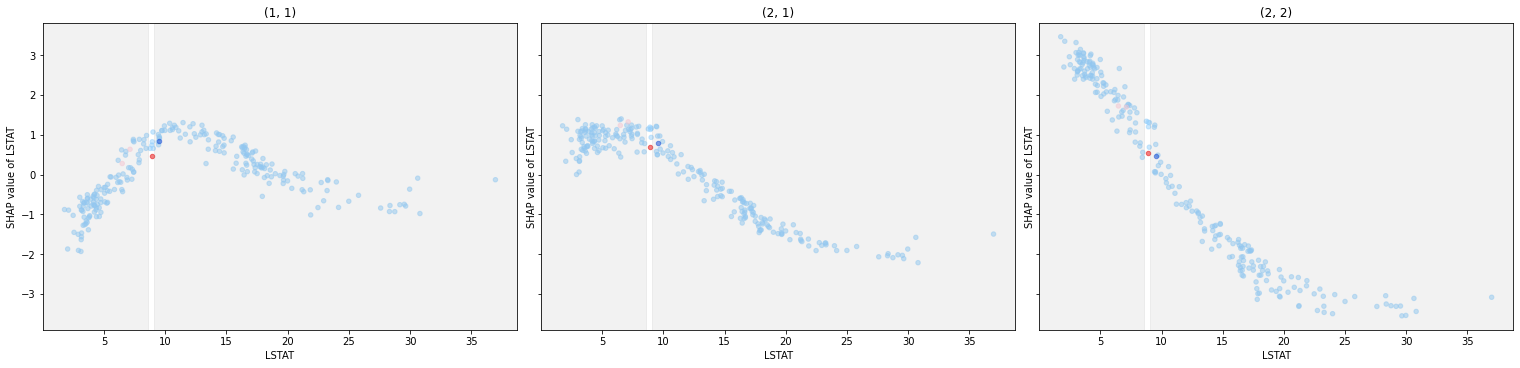

ZN == 33.0
ZN <= 24.0 --> {'(1, 1)': 1}
ZN >= 62.0 --> {'(2, 2)': 1}


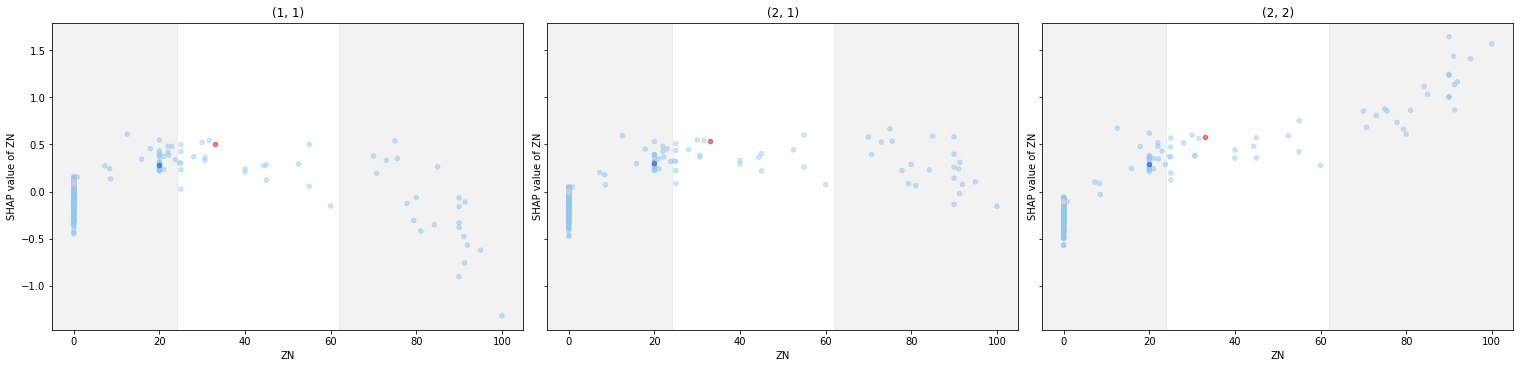

In [110]:
for feature in node.feature_names_relevant[:2]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)

### Node RRRRRRLL

In [112]:
node = node.root.get('RRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RRRRRRLL,
 (2, 1)    1
 dtype: int64,
 0)

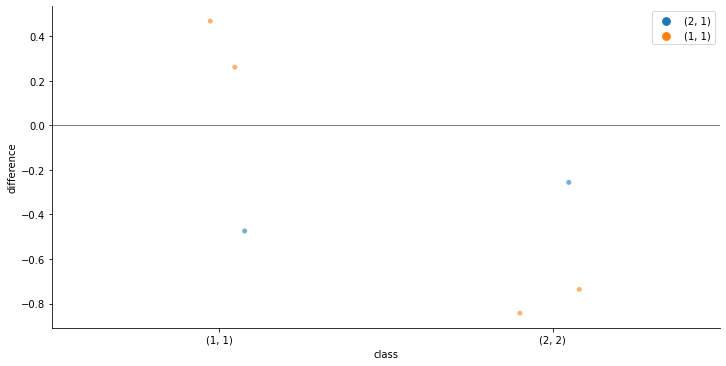

{'(1, 1)': '-0.47 to -0.47', '(2, 2)': '-0.26 to -0.26'}


In [113]:
node.get_parent().plot_outcome_differences()

LSTAT == 6.48
LSTAT <= 5.97 --> {'(2, 2)': 1}
LSTAT >= 7.32 --> {'(1, 1)': 1}


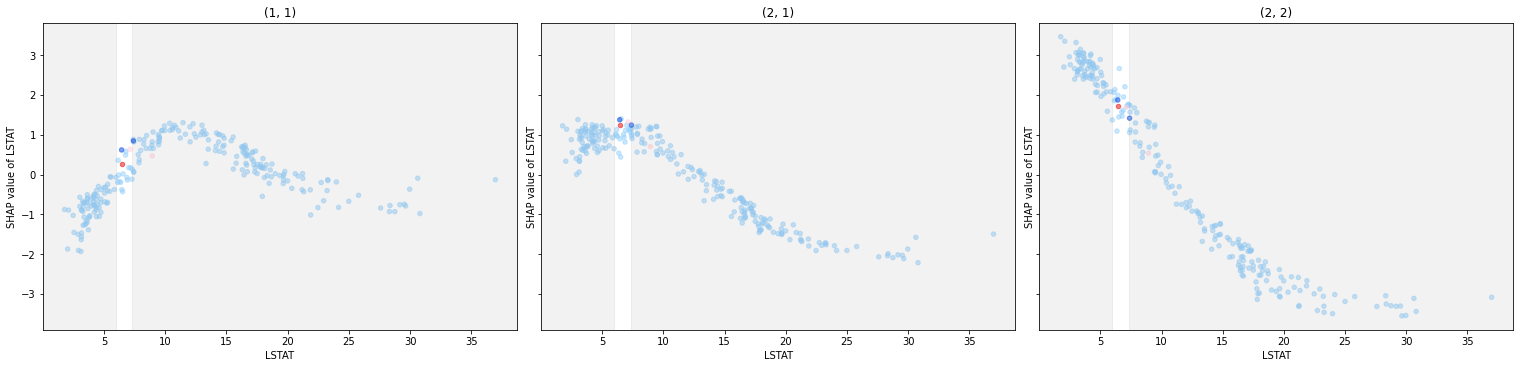

AGE == 2.0
AGE <= 1.0 --> {'(1, 2)': 1}


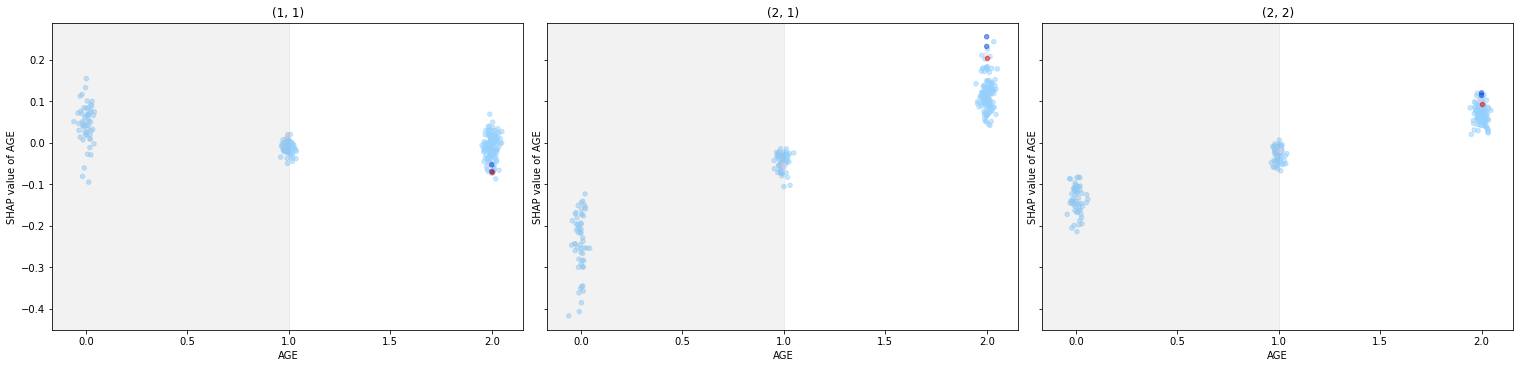

TAX == 273.0
TAX >= 593.0 --> {'(2, 2)': 1}


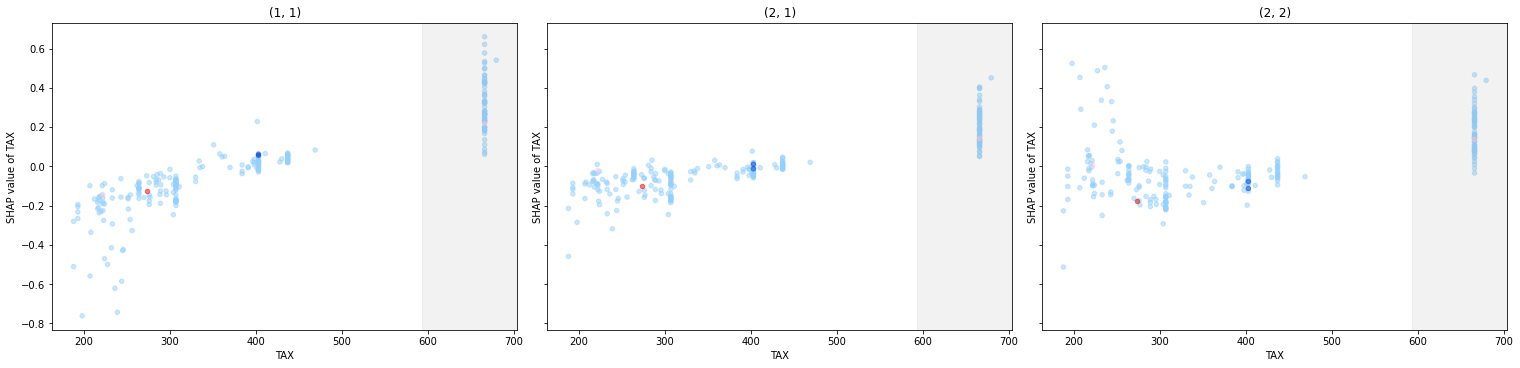

RAD == 1.0
RAD >= 3.9 --> {'(2, 2)': 1}


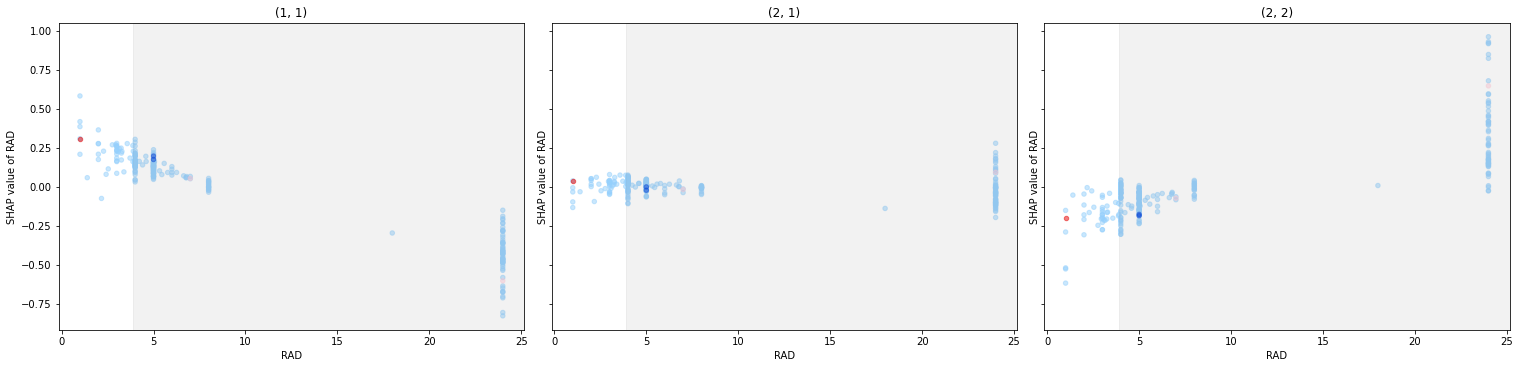

DIS == 2.3889
DIS <= 1.41 --> {'(2, 2)': 1}
DIS >= 4.18 --> {'(1, 1)': 1}


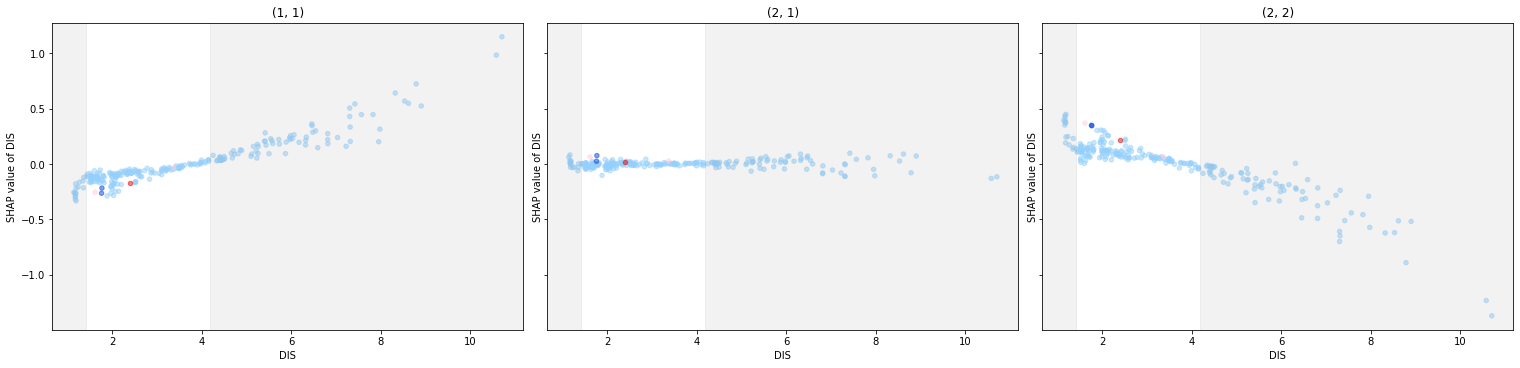

CRIM == 0.10959
CRIM >= 6.0 --> {'(2, 2)': 1}


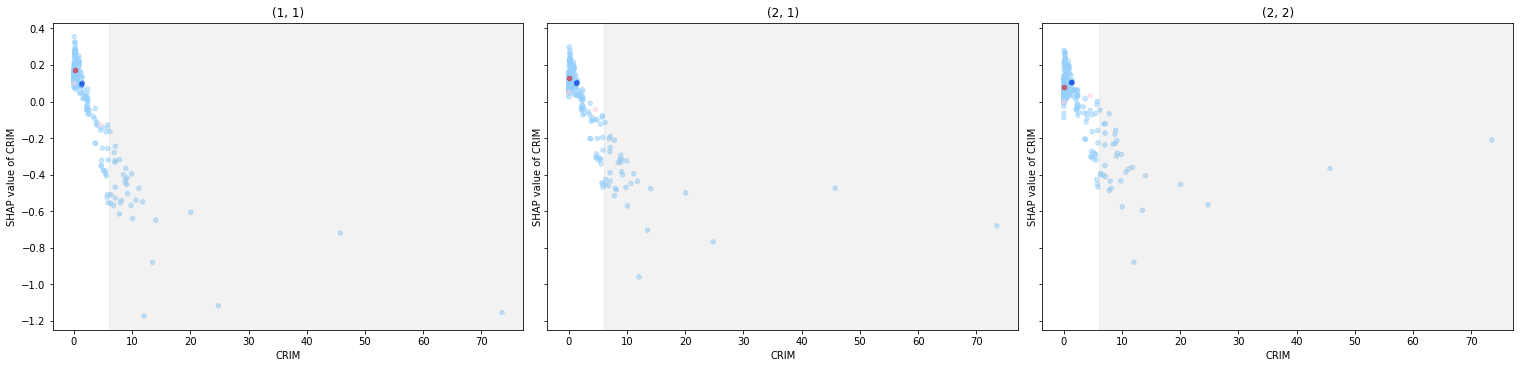

ZN == 0.0
ZN >= 40.0 --> {'(2, 2)': 1}


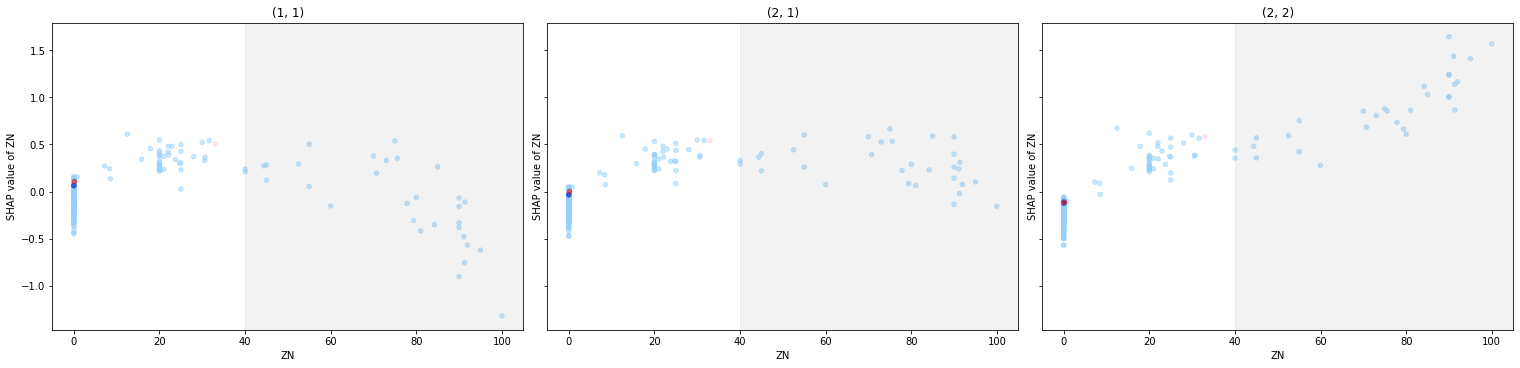

INDUS == 11.93
INDUS <= 8.77 --> {'(2, 2)': 1}
INDUS >= 16.32 --> {'(1, 1)': 1}


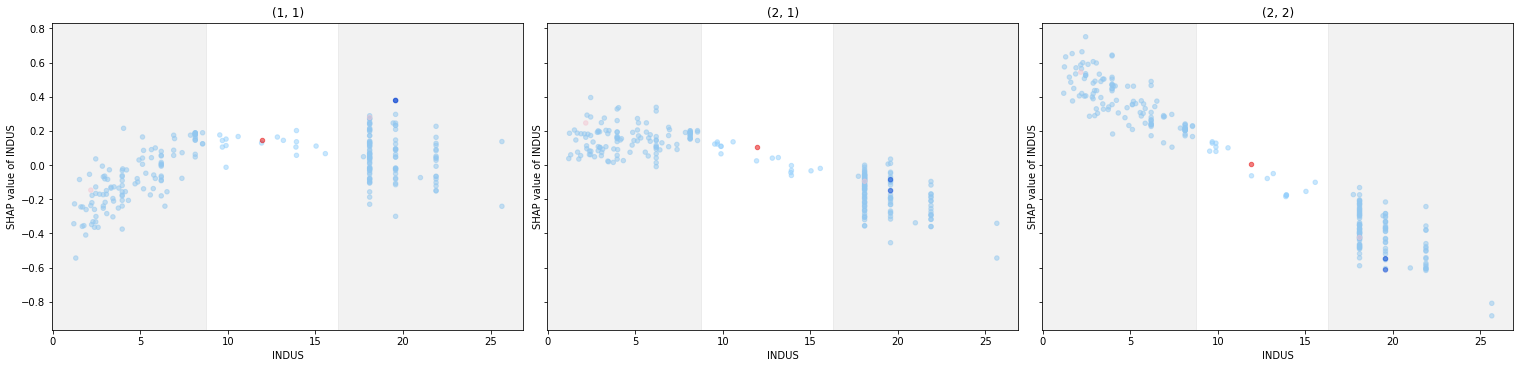

RM == 6.794
RM <= 6.06 --> {'(1, 1)': 1}
RM >= 7.22 --> {'(2, 2)': 1}


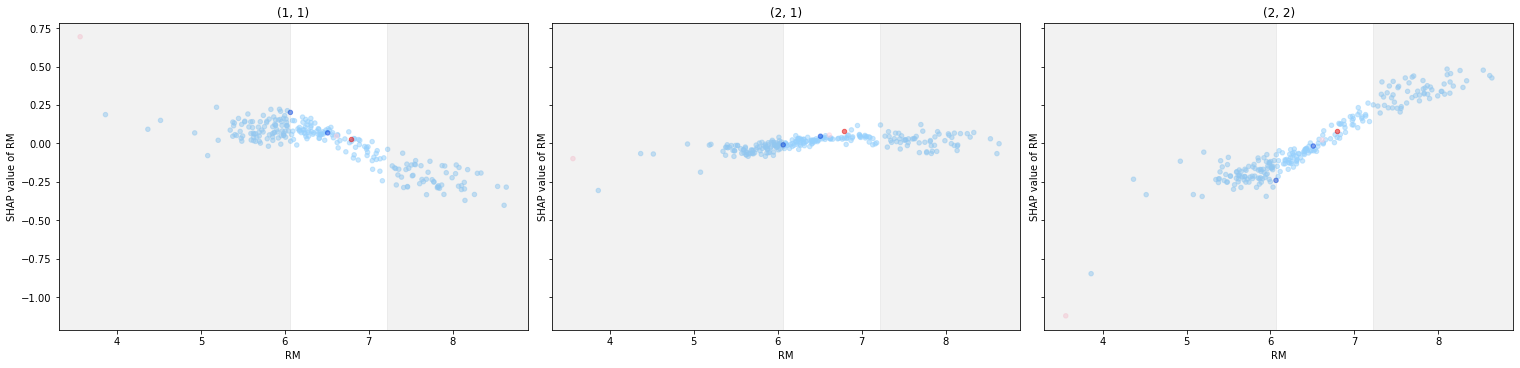

In [116]:
for feature in node.feature_names_relevant[:]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(), alpha=0.5)